In [ ]:
import pandas as pd
!pip install pandasql
from pandasql import sqldf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.api as sm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data Cleaning and Wrangling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df.head()

Month  Monthly milk production: pounds per cow
0  1962-01                                    589.0
1  1962-02                                    561.0
2  1962-03                                    640.0
3  1962-04                                    656.0
4  1962-05                                    727.0

In [ ]:
df = df.rename(columns = {'Monthly milk production: pounds per cow': 'Milk_Prod'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      169 non-null    object 
 1   Milk_Prod  168 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df.isnull().sum()

Month        1
Milk_Prod    2
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isnull().sum()

Month        0
Milk_Prod    0
dtype: int64

In [ ]:
df.describe()

Milk_Prod
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000

In [ ]:
Query_string = """ select * from df where Milk_Prod > 500 ORDER BY Milk_Prod DESC"""
sqldf(Query_string, globals())

Month  Milk_Prod
0    1974-05      969.0
1    1975-05      966.0
2    1972-05      961.0
3    1973-05      957.0
4    1974-06      947.0
..       ...        ...
163  1962-09      568.0
164  1963-02      566.0
165  1963-11      565.0
166  1962-02      561.0
167  1962-11      553.0

[168 rows x 2 columns]

#Data Decomposition




### 1) Multiple Box Plot

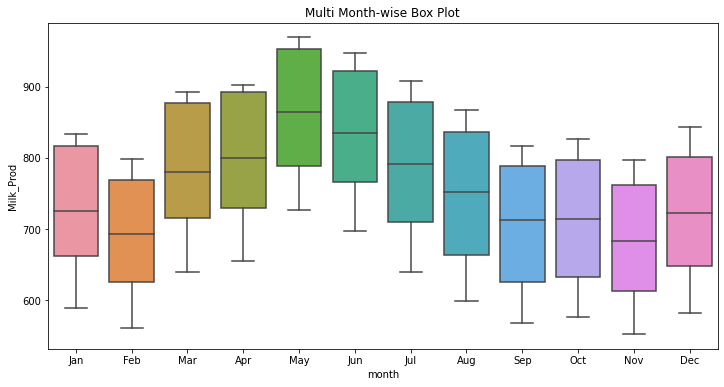

In [ ]:
df['Month'] = pd.to_datetime(df['Month'], errors='coerce')
df['month'] = df['Month'].dt.strftime('%b')

df['year'] = [d.year for d in df.Month]

df['month'] = [d.strftime('%b') for d in df.Month]

years = df['year'].unique()
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='Milk_Prod', data=df).set_title("Multi Month-wise Box Plot")
plt.show()

### 2) Seasonality using auto correlation

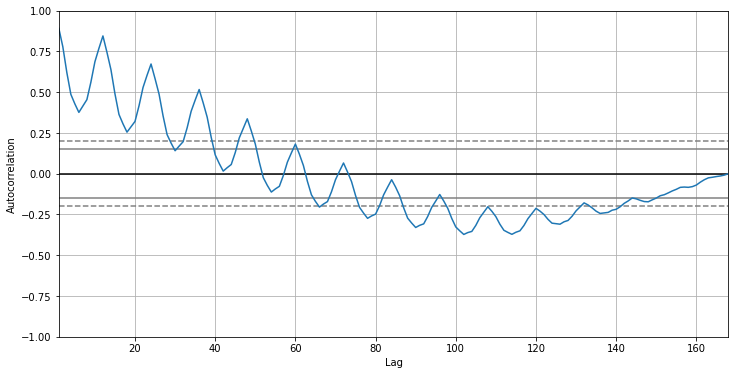

In [ ]:
plt.rcParams.update({'figure.figsize':(12,6)})
autocorrelation_plot(df.Milk_Prod.tolist())

### 3) Deseasoning the time series

#### a) Additive model

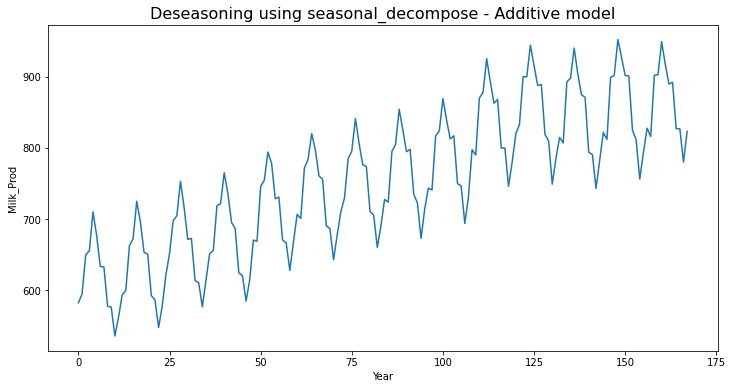

In [ ]:
result_mul = seasonal_decompose(df['Milk_Prod'], model='additive', freq = 6)
deseason = df['Milk_Prod'] - result_mul.seasonal
plt.figure(figsize=(12,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose - Additive model', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Milk_Prod')
plt.show()

#### b) Multiplicative model

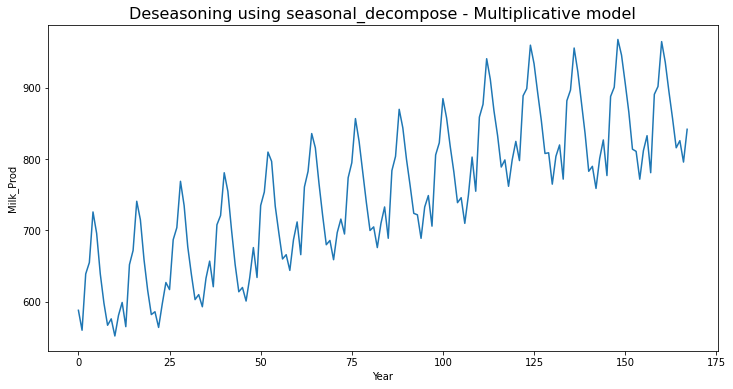

In [ ]:
result_mul = seasonal_decompose(df['Milk_Prod'], model='multiplicative', freq = 6)
deseason = df['Milk_Prod'] - result_mul.seasonal
plt.figure(figsize=(12,6))
plt.plot(deseason)
plt.title('Deseasoning using seasonal_decompose - Multiplicative model', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Milk_Prod')
plt.show()

### 4) Seasonal Decomposition

#### a) From Scratch

In [ ]:
dtemp = df["Milk_Prod"]
dtemp.head()

0    589.0
1    561.0
2    640.0
3    656.0
4    727.0
Name: Milk_Prod, dtype: float64

Text(0.5, 1.0, 'Trend against Time')

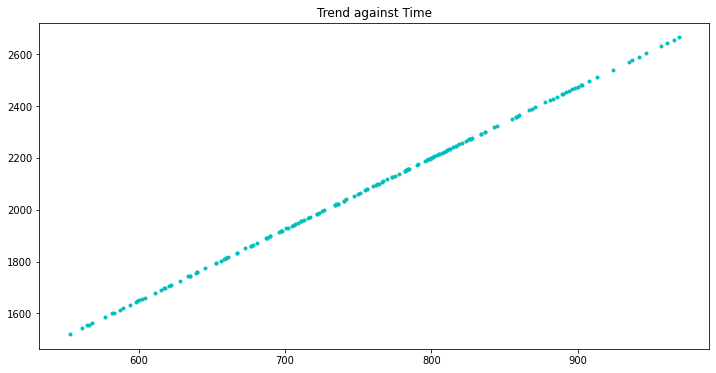

In [ ]:
#create the trend component
T_Series = dtemp
Trend = T_Series * 2.75

#plot the trend
plt.plot(T_Series, Trend, 'c.')
plt.title("Trend against Time")

Text(0.5, 1.0, 'Seasonality against Time')

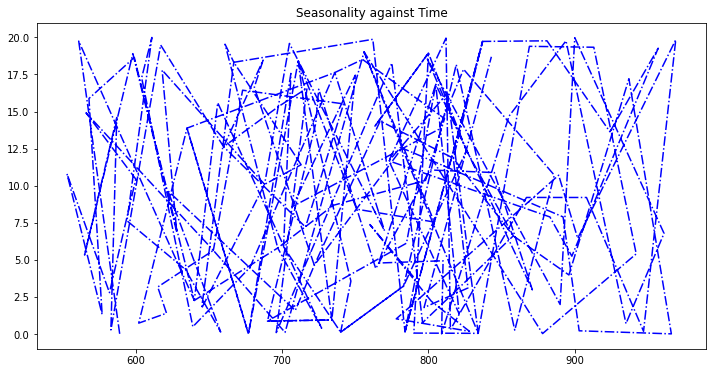

In [ ]:
# creating the seasonality component
seasonality = 10 + np.sin(T_Series) * 10

#plot the seasonality trend
plt.plot(T_Series,  seasonality, 'b-.')
plt.title("Seasonality against Time")

Text(0.5, 1.0, 'Residuals against Time')

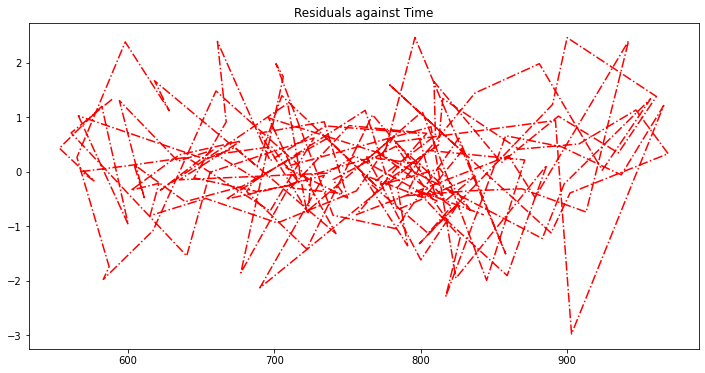

In [ ]:
#creating the residual component
np.random.seed(10)  # for result reproducibility
residual = np.random.normal(loc=0.0, scale=1, size=len(T_Series))

#plot the residual component
plt.plot(T_Series, residual, 'r-.')
plt.title("Residuals against Time")

Text(0.5, 1.0, 'Additive Time Series')

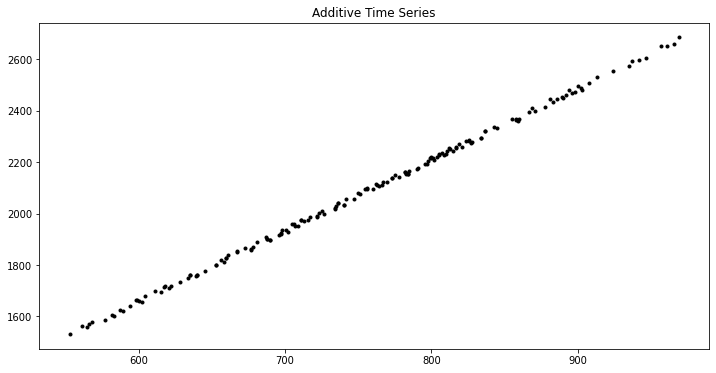

In [ ]:
#create an additive model of our time series
additive_Tmodel = Trend + seasonality + residual

#Plot the additive model
plt.plot(T_Series, additive_Tmodel, 'k.')
plt.title("Additive Time Series")

Text(0.5, 1.0, 'Multiplicative Time Series')

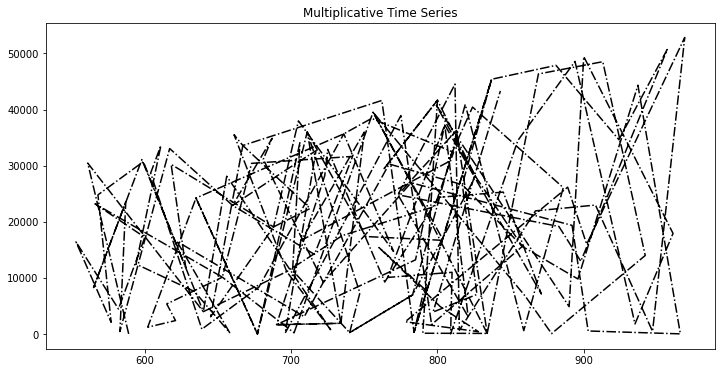

In [ ]:
ignored_residual = np.ones_like(residual)

multiplicative_Tmodel = Trend * seasonality * ignored_residual

plt.plot(T_Series, multiplicative_Tmodel, 'k-.')
plt.title("Multiplicative Time Series")

#### b) Using libraries

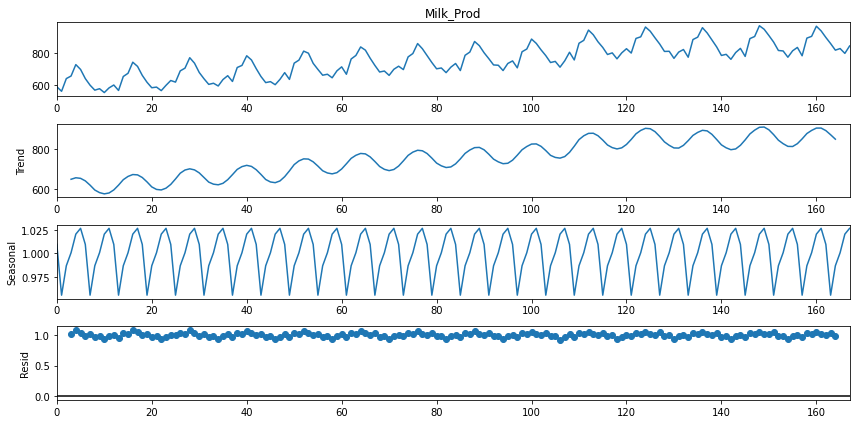

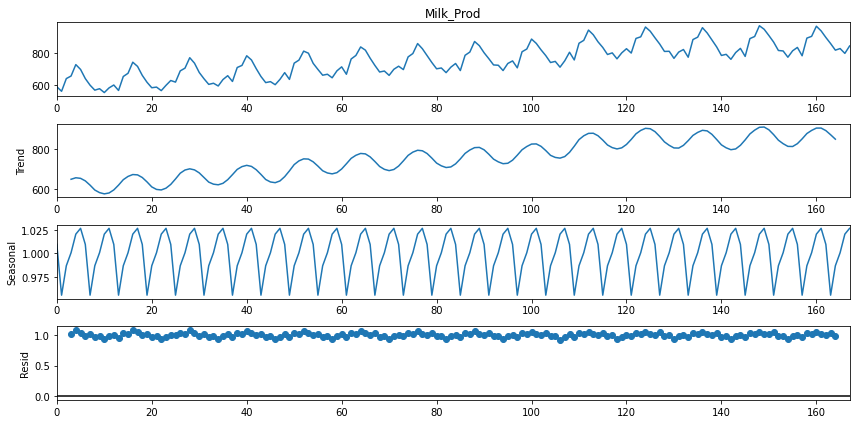

In [ ]:
result = seasonal_decompose(df['Milk_Prod'], model='mul',freq =6)
result.plot()

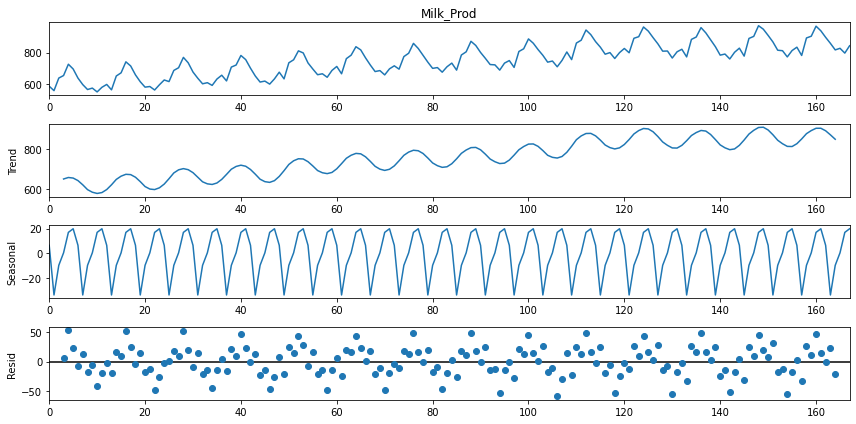

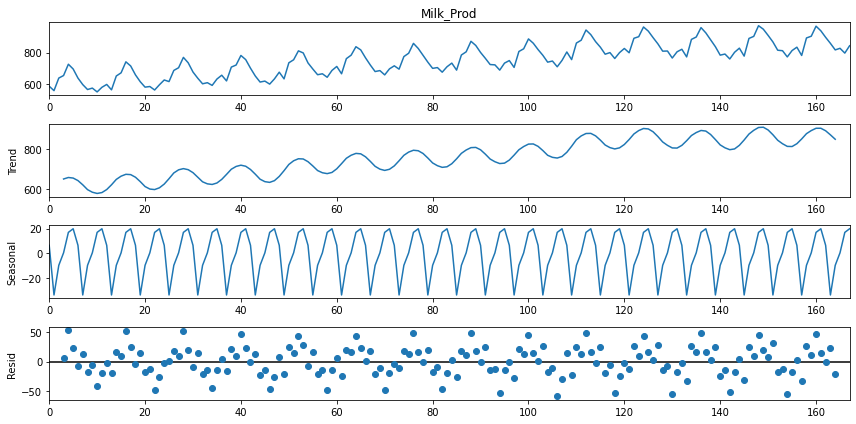

In [ ]:
result = seasonal_decompose(df['Milk_Prod'], model='add', freq =6)
result.plot()

#Smoothing Methods

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd
import numpy as np
from sklearn import metrics
from timeit import default_timer as timer
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.api import ExponentialSmoothing

In [ ]:
df = pd.read_csv('/content/monthly-milk-production-pounds.csv')
df.head()

Month  Monthly milk production: pounds per cow
0  1962-01                                    589.0
1  1962-02                                    561.0
2  1962-03                                    640.0
3  1962-04                                    656.0
4  1962-05                                    727.0

In [ ]:
df.rename(columns = {'Monthly milk production: pounds per cow': 'Milk_prod'},inplace = True)
df.head()

Month  Milk_prod
0  1962-01      589.0
1  1962-02      561.0
2  1962-03      640.0
3  1962-04      656.0
4  1962-05      727.0

In [ ]:
df.isna().sum()

Month        1
Milk_prod    2
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

Month        0
Milk_prod    0
dtype: int64

### 1) Simple Exponential Smoothing

In [ ]:
X = df['Milk_prod']
test = X.iloc[-30:]
train = X.iloc[:-30]

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
resu = []
temp_df = pd.DataFrame()
#df2 = pd.DataFrame(columns=['smoothing parameter', 'RMSE'])
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(30)
    timeseries_evaluation_metrics_func(test,fcst_pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE'])

Fitting for smoothing level= 0
Evaluation metric results:-
MSE is : 16985.96947069941
MAE is : 116.33188405797088
RMSE is : 130.33023237414798
MAPE is : 13.27797084371963
R2 is : -3.9193881416349816

Fitting for smoothing level= 0.1
Evaluation metric results:-
MSE is : 3517.071215204116
MAE is : 51.85594361636404
RMSE is : 59.304900431617924
MAPE is : 6.124877210087668
R2 is : -0.018595874625014774

Fitting for smoothing level= 0.2
Evaluation metric results:-
MSE is : 4212.226184062051
MAE is : 56.48619359781448
RMSE is : 64.90166549528641
MAPE is : 6.802978811519342
R2 is : -0.21992304151397968

Fitting for smoothing level= 0.3
Evaluation metric results:-
MSE is : 5388.227814207426
MAE is : 62.25441321719495
RMSE is : 73.40454900213899
MAPE is : 7.586323683542642
R2 is : -0.5605105177754892

Fitting for smoothing level= 0.4
Evaluation metric results:-
MSE is : 6803.76166678444
MAE is : 70.31265516292919
RMSE is : 82.48491781401276
MAPE is : 8.60434178419193
R2 is : -0.9704700705971461

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handl

smoothing parameter        RMSE
1                   0.1   59.304900
2                   0.2   64.901665
3                   0.3   73.404549
4                   0.4   82.484918
5                   0.5   89.811139
10                  1.0   94.283968
6                   0.6   94.582825
9                   0.9   96.397829
7                   0.7   96.961013
8                   0.8   97.410464
0                   0.0  130.330232

In [ ]:
#using values from grid search
fitSES = SimpleExpSmoothing(np.asarray(train)).fit( smoothing_level = 0.1,optimized= False)
fcst_gs_pred = fitSES.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_gs_pred)

Evaluation metric results:-
MSE is : 3517.07092057287
MAE is : 51.85593993946782
RMSE is : 59.304897947579924
MAPE is : 6.124876650488856
R2 is : -0.018595789295445364



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
#Automated smoothing_level
fitSESauto = SimpleExpSmoothing(np.asarray(train)).fit( optimized= True, use_brute = True)
fcst_auto_pred = fitSESauto.forecast(30)
timeseries_evaluation_metrics_func(test,fcst_auto_pred)

Evaluation metric results:-
MSE is : 8889.466739181678
MAE is : 81.93333369394144
RMSE is : 94.28396862235742
MAPE is : 10.03407293485807
R2 is : -1.5745211268408275



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
fitSESauto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                  endog   No. Observations:                  138
Model:             SimpleExpSmoothing   SSE                         275891.000
Optimized:                       True   AIC                           1052.870
Trend:                           None   BIC                           1058.725
Seasonal:                        None   AICC                          1053.171
Seasonal Periods:                None   Date:                 Tue, 11 Oct 2022
Box-Cox:                        False   Time:                         16:40:35
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              589.00011                  l.0                 True
------------------------------------------------------------------------------
"""

In [ ]:
df_fcst_gs_pred = pd.DataFrame(fcst_gs_pred, columns=['Close_grid_Search'])
df_fcst_gs_pred["new_index"] = range(1229    , 1259)
df_fcst_gs_pred = df_fcst_gs_pred.set_index("new_index")

In [ ]:
df_fcst_auto_pred = pd.DataFrame(fcst_auto_pred, columns=['Close_auto_search'])
df_fcst_auto_pred["new_index"] = range(1229    , 1259)
df_fcst_auto_pred = df_fcst_auto_pred.set_index("new_index")

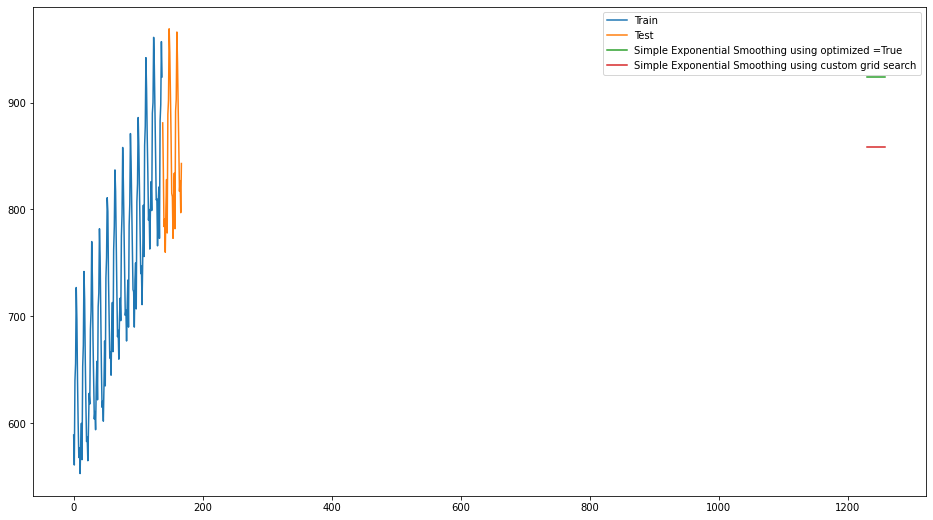

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(df_fcst_auto_pred, label='Simple Exponential Smoothing using optimized =True')
plt.plot(df_fcst_gs_pred, label='Simple Exponential Smoothing using custom grid search')
plt.legend(loc='best')
plt.show()

### 2) Double Exponential Smoothing

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
#Holt Parameters:
#    endog (array-like) – Time series
#    expoential (bool, optional) – Type of trend component.
#    damped (bool, optional) – Should the trend component be damped.

In [ ]:
#fit Parameters:
#    smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
#    smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
#    damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
#    optimized (bool, optional) – Should the values that have not been set above be optimized automatically?

In [ ]:
df_results_moni = pd.DataFrame(columns=['smoothing_level', 'smoothing_slope', 'damping_slope','damped','RMSE','r2'])
start = timer()
for a,b in enumerate(pg):
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    print(smoothing_level, smoothing_slope, damping_slope,damped)
    fit1 = Holt(train,damped =damped ).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope = damping_slope ,optimized=False)
    #fit1.summary
    z = fit1.forecast(30)
    print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'smoothing_level' :smoothing_level, 'smoothing_slope':smoothing_slope, 'damping_slope' :damping_slope,'damped':damped,'RMSE': RMSE,'r2':r2}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

0.1 0.1 0.1 True
138    858.571788
139    858.580315
140    858.581167
141    858.581252
142    858.581261
143    858.581262
144    858.581262
145    858.581262
146    858.581262
147    858.581262
148    858.581262
149    858.581262
150    858.581262
151    858.581262
152    858.581262
153    858.581262
154    858.581262
155    858.581262
156    858.581262
157    858.581262
158    858.581262
159    858.581262
160    858.581262
161    858.581262
162    858.581262
163    858.581262
164    858.581262
165    858.581262
166    858.581262
167    858.581262
dtype: float64
 RMSE is 59.346499439269586
0.1 0.2 0.1 True
138    858.859428
139    858.876433
140    858.878134
141    858.878304
142    858.878321
143    858.878323
144    858.878323
145    858.878323
146    858.878323
147    858.878323
148    858.878323
149    858.878323
150    858.878323
151    858.878323
152    858.878323
153    858.878323
154    858.878323
155    858.878323
156    858.878323
157    858.878323
158    858.878323
159  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    880.411210
139    880.506013
140    880.515493
141    880.516441
142    880.516536
143    880.516545
144    880.516546
145    880.516546
146    880.516546
147    880.516546
148    880.516546
149    880.516546
150    880.516546
151    880.516546
152    880.516546
153    880.516546
154    880.516546
155    880.516546
156    880.516546
157    880.516546
158    880.516546
159    880.516546
160    880.516546
161    880.516546
162    880.516546
163    880.516546
164    880.516546
165    880.516546
166    880.516546
167    880.516546
dtype: float64
 RMSE is 66.08996250353877
0.2 0.8 0.1 True
138    880.780349
139    880.888208
140    880.898994
141    880.900072
142    880.900180
143    880.900191
144    880.900192
145    880.900192
146    880.900192
147    880.900192
148    880.900192
149    880.900192
150    880.900192
151    880.900192
152    880.900192
153    880.900192
154    880.900192
155    880.900192
156    880.900192
157    880.900192
158    880.900192
159    880.900192
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.4 0.5 0.1 True
138    910.812619
139    910.879690
140    910.886397
141    910.887068
142    910.887135
143    910.887142
144    910.887142
145    910.887143
146    910.887143
147    910.887143
148    910.887143
149    910.887143
150    910.887143
151    910.887143
152    910.887143
153    910.887143
154    910.887143
155    910.887143
156    910.887143
157    910.887143
158    910.887143
159    910.887143
160    910.887143
161    910.887143
162    910.887143
163    910.887143
164    910.887143
165    910.887143
166    910.887143
167    910.887143
dtype: float64
 RMSE is 84.42459553926264
0.4 0.6 0.1 True
138    911.323449
139    911.402257
140    911.410138
141    911.410926
142    911.411005
143    911.411012
144    911.411013
145    911.411013
146    911.411013
147    911.411013
148    911.411013
149    911.411013
150    911.411013
151    911.411013
152    911.411013
153    911.411013
154    911.411013
155    911.411013
156    911.411013
157    911.411013
158    911.411013
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    922.031916
139    922.096526
140    922.102987
141    922.103633
142    922.103698
143    922.103704
144    922.103705
145    922.103705
146    922.103705
147    922.103705
148    922.103705
149    922.103705
150    922.103705
151    922.103705
152    922.103705
153    922.103705
154    922.103705
155    922.103705
156    922.103705
157    922.103705
158    922.103705
159    922.103705
160    922.103705
161    922.103705
162    922.103705
163    922.103705
164    922.103705
165    922.103705
166    922.103705
167    922.103705
dtype: float64
 RMSE is 92.80720701625125
0.6 0.1 0.1 True
138    924.717936
139    924.722063
140    924.722475
141    924.722517
142    924.722521
143    924.722521
144    924.722521
145    924.722521
146    924.722521
147    924.722521
148    924.722521
149    924.722521
150    924.722521
151    924.722521
152    924.722521
153    924.722521
154    924.722521
155    924.722521
156    924.722521
157    924.722521
158    924.722521
159    924.722521
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.7 0.6 0.1 True
138    928.279837
139    928.246367
140    928.243020
141    928.242685
142    928.242652
143    928.242649
144    928.242648
145    928.242648
146    928.242648
147    928.242648
148    928.242648
149    928.242648
150    928.242648
151    928.242648
152    928.242648
153    928.242648
154    928.242648
155    928.242648
156    928.242648
157    928.242648
158    928.242648
159    928.242648
160    928.242648
161    928.242648
162    928.242648
163    928.242648
164    928.242648
165    928.242648
166    928.242648
167    928.242648
dtype: float64
 RMSE is 97.63841290251601
0.7 0.7 0.1 True
138    928.382626
139    928.340152
140    928.335905
141    928.335480
142    928.335437
143    928.335433
144    928.335433
145    928.335433
146    928.335433
147    928.335433
148    928.335433
149    928.335433
150    928.335433
151    928.335433
152    928.335433
153    928.335433
154    928.335433
155    928.335433
156    928.335433
157    928.335433
158    928.335433
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    927.793084
139    927.676977
140    927.665367
141    927.664206
142    927.664089
143    927.664078
144    927.664077
145    927.664077
146    927.664077
147    927.664077
148    927.664077
149    927.664077
150    927.664077
151    927.664077
152    927.664077
153    927.664077
154    927.664077
155    927.664077
156    927.664077
157    927.664077
158    927.664077
159    927.664077
160    927.664077
161    927.664077
162    927.664077
163    927.664077
164    927.664077
165    927.664077
166    927.664077
167    927.664077
dtype: float64
 RMSE is 97.17877772501328
0.8 0.9 0.1 True
138    927.718437
139    927.583306
140    927.569793
141    927.568442
142    927.568307
143    927.568293
144    927.568292
145    927.568292
146    927.568291
147    927.568291
148    927.568291
149    927.568291
150    927.568291
151    927.568291
152    927.568291
153    927.568291
154    927.568291
155    927.568291
156    927.568291
157    927.568291
158    927.568291
159    927.568291
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    860.674266
139    860.830381
140    860.861605
141    860.867849
142    860.869098
143    860.869348
144    860.869398
145    860.869408
146    860.869410
147    860.869410
148    860.869410
149    860.869410
150    860.869410
151    860.869410
152    860.869410
153    860.869410
154    860.869410
155    860.869410
156    860.869410
157    860.869410
158    860.869410
159    860.869410
160    860.869410
161    860.869410
162    860.869410
163    860.869410
164    860.869410
165    860.869410
166    860.869410
167    860.869410
dtype: float64
 RMSE is 59.711237158836695
0.1 0.5 0.2 True
138    861.228097
139    861.422371
140    861.461226
141    861.468997
142    861.470551
143    861.470862
144    861.470924
145    861.470937
146    861.470939
147    861.470940
148    861.470940
149    861.470940
150    861.470940
151    861.470940
152    861.470940
153    861.470940
154    861.470940
155    861.470940
156    861.470940
157    861.470940
158    861.470940
159    861.470940
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    885.057060
139    885.618272
140    885.730514
141    885.752962
142    885.757452
143    885.758350
144    885.758530
145    885.758566
146    885.758573
147    885.758574
148    885.758574
149    885.758574
150    885.758574
151    885.758574
152    885.758574
153    885.758574
154    885.758574
155    885.758574
156    885.758574
157    885.758574
158    885.758574
159    885.758574
160    885.758574
161    885.758574
162    885.758574
163    885.758574
164    885.758574
165    885.758574
166    885.758574
167    885.758574
dtype: float64
 RMSE is 68.64138332852382
0.3 0.1 0.2 True
138    895.396862
139    895.476376
140    895.492279
141    895.495459
142    895.496095
143    895.496223
144    895.496248
145    895.496253
146    895.496254
147    895.496254
148    895.496254
149    895.496254
150    895.496254
151    895.496254
152    895.496254
153    895.496254
154    895.496254
155    895.496254
156    895.496254
157    895.496254
158    895.496254
159    895.496254
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    915.114775
139    915.498876
140    915.575697
141    915.591061
142    915.594133
143    915.594748
144    915.594871
145    915.594896
146    915.594900
147    915.594901
148    915.594902
149    915.594902
150    915.594902
151    915.594902
152    915.594902
153    915.594902
154    915.594902
155    915.594902
156    915.594902
157    915.594902
158    915.594902
159    915.594902
160    915.594902
161    915.594902
162    915.594902
163    915.594902
164    915.594902
165    915.594902
166    915.594902
167    915.594902
dtype: float64
 RMSE is 87.85686248932477
0.4 0.7 0.2 True
138    916.166277
139    916.596944
140    916.683077
141    916.700303
142    916.703749
143    916.704438
144    916.704576
145    916.704603
146    916.704609
147    916.704610
148    916.704610
149    916.704610
150    916.704610
151    916.704610
152    916.704610
153    916.704610
154    916.704610
155    916.704610
156    916.704610
157    916.704610
158    916.704610
159    916.704610
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 96.49117886677513
0.6 0.4 0.2 True
138    927.350134
139    927.452472
140    927.472940
141    927.477033
142    927.477852
143    927.478016
144    927.478049
145    927.478055
146    927.478057
147    927.478057
148    927.478057
149    927.478057
150    927.478057
151    927.478057
152    927.478057
153    927.478057
154    927.478057
155    927.478057
156    927.478057
157    927.478057
158    927.478057
159    927.478057
160    927.478057
161    927.478057
162    927.478057
163    927.478057
164    927.478057
165    927.478057
166    927.478057
167    927.478057
dtype: float64
 RMSE is 97.02499631683558
0.6 0.5 0.2 True
138    927.951606
139    928.059115
140    928.080616
141    928.084917
142    928.085777
143    928.085949
144    928.085983
145    928.085990
146    928.085991
147    928.085992
148    928.085992
149    928.085992
150    928.085992
151    928.085992
152    928.085992
153    928.085992
154    928.085992
155    928.085992
156    928.085992
157    928.0859

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    929.847835
139    929.681329
140    929.648028
141    929.641367
142    929.640035
143    929.639769
144    929.639716
145    929.639705
146    929.639703
147    929.639702
148    929.639702
149    929.639702
150    929.639702
151    929.639702
152    929.639702
153    929.639702
154    929.639702
155    929.639702
156    929.639702
157    929.639702
158    929.639702
159    929.639702
160    929.639702
161    929.639702
162    929.639702
163    929.639702
164    929.639702
165    929.639702
166    929.639702
167    929.639702
dtype: float64
 RMSE is 98.7622153362959
0.7 0.9 0.2 True
138    929.918646
139    929.695588
140    929.650977
141    929.642055
142    929.640270
143    929.639913
144    929.639842
145    929.639827
146    929.639825
147    929.639824
148    929.639824
149    929.639824
150    929.639824
151    929.639824
152    929.639824
153    929.639824
154    929.639824
155    929.639824
156    929.639824
157    929.639824
158    929.639824
159    929.639824
160   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 95.47277014588498
0.9 0.5 0.2 True
138    925.496454
139    925.133916
140    925.061408
141    925.046906
142    925.044006
143    925.043426
144    925.043310
145    925.043287
146    925.043282
147    925.043281
148    925.043281
149    925.043281
150    925.043281
151    925.043281
152    925.043281
153    925.043281
154    925.043281
155    925.043281
156    925.043281
157    925.043281
158    925.043281
159    925.043281
160    925.043281
161    925.043281
162    925.043281
163    925.043281
164    925.043281
165    925.043281
166    925.043281
167    925.043281
dtype: float64
 RMSE is 95.11301839310576
0.9 0.6 0.2 True
138    925.103360
139    924.639717
140    924.546988
141    924.528443
142    924.524734
143    924.523992
144    924.523843
145    924.523814
146    924.523808
147    924.523807
148    924.523806
149    924.523806
150    924.523806
151    924.523806
152    924.523806
153    924.523806
154    924.523806
155    924.523806
156    924.523806
157    924.5238

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    879.108527
139    879.285550
140    879.338657
141    879.354589
142    879.359369
143    879.360803
144    879.361233
145    879.361362
146    879.361401
147    879.361412
148    879.361416
149    879.361417
150    879.361417
151    879.361417
152    879.361417
153    879.361417
154    879.361417
155    879.361417
156    879.361417
157    879.361417
158    879.361417
159    879.361417
160    879.361417
161    879.361417
162    879.361417
163    879.361417
164    879.361417
165    879.361417
166    879.361417
167    879.361417
dtype: float64
 RMSE is 65.56658517103939
0.2 0.2 0.3 True
138    880.401223
139    880.752303
140    880.857627
141    880.889225
142    880.898704
143    880.901548
144    880.902401
145    880.902657
146    880.902733
147    880.902756
148    880.902763
149    880.902765
150    880.902766
151    880.902766
152    880.902766
153    880.902766
154    880.902766
155    880.902766
156    880.902766
157    880.902766
158    880.902766
159    880.902766
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.7 0.3 True
138    907.095953
139    908.407268
140    908.800663
141    908.918681
142    908.954086
143    908.964708
144    908.967895
145    908.968851
146    908.969137
147    908.969223
148    908.969249
149    908.969257
150    908.969259
151    908.969260
152    908.969260
153    908.969260
154    908.969260
155    908.969260
156    908.969260
157    908.969260
158    908.969260
159    908.969260
160    908.969260
161    908.969260
162    908.969260
163    908.969260
164    908.969260
165    908.969260
166    908.969260
167    908.969260
dtype: float64
 RMSE is 83.010837752681
0.3 0.8 0.3 True
138    908.827133
139    910.280843
140    910.716956
141    910.847790
142    910.887040
143    910.898815
144    910.902348
145    910.903407
146    910.903725
147    910.903821
148    910.903849
149    910.903858
150    910.903860
151    910.903861
152    910.903861
153    910.903862
154    910.903862
155    910.903862
156    910.903862
157    910.903862
158    910.903862
159    9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 93.0348408417123
0.5 0.3 0.3 True
138    923.583442
139    924.080435
140    924.229533
141    924.274263
142    924.287681
143    924.291707
144    924.292915
145    924.293277
146    924.293386
147    924.293418
148    924.293428
149    924.293431
150    924.293432
151    924.293432
152    924.293432
153    924.293432
154    924.293432
155    924.293432
156    924.293432
157    924.293432
158    924.293432
159    924.293432
160    924.293432
161    924.293432
162    924.293432
163    924.293432
164    924.293432
165    924.293432
166    924.293432
167    924.293432
dtype: float64
 RMSE is 94.49181964765822
0.5 0.4 0.3 True
138    925.144440
139    925.753653
140    925.936417
141    925.991247
142    926.007695
143    926.012630
144    926.014110
145    926.014554
146    926.014688
147    926.014728
148    926.014740
149    926.014743
150    926.014744
151    926.014745
152    926.014745
153    926.014745
154    926.014745
155    926.014745
156    926.014745
157    926.01474

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.6 0.8 0.3 True
138    932.609352
139    932.902060
140    932.989872
141    933.016216
142    933.024119
143    933.026490
144    933.027201
145    933.027415
146    933.027479
147    933.027498
148    933.027504
149    933.027506
150    933.027506
151    933.027506
152    933.027506
153    933.027506
154    933.027506
155    933.027506
156    933.027506
157    933.027506
158    933.027506
159    933.027506
160    933.027506
161    933.027506
162    933.027506
163    933.027506
164    933.027506
165    933.027506
166    933.027506
167    933.027506
dtype: float64
 RMSE is 101.4861558210663
0.6 0.9 0.3 True
138    933.077321
139    933.287039
140    933.349955
141    933.368830
142    933.374492
143    933.376191
144    933.376700
145    933.376853
146    933.376899
147    933.376913
148    933.376917
149    933.376918
150    933.376919
151    933.376919
152    933.376919
153    933.376919
154    933.376919
155    933.376919
156    933.376919
157    933.376919
158    933.376919
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    929.133353
139    928.967561
140    928.917823
141    928.902902
142    928.898426
143    928.897083
144    928.896680
145    928.896559
146    928.896523
147    928.896512
148    928.896509
149    928.896508
150    928.896507
151    928.896507
152    928.896507
153    928.896507
154    928.896507
155    928.896507
156    928.896507
157    928.896507
158    928.896507
159    928.896507
160    928.896507
161    928.896507
162    928.896507
163    928.896507
164    928.896507
165    928.896507
166    928.896507
167    928.896507
dtype: float64
 RMSE is 98.16822582188372
0.8 0.5 0.3 True
138    929.069018
139    928.772047
140    928.682955
141    928.656228
142    928.648210
143    928.645804
144    928.645083
145    928.644866
146    928.644801
147    928.644782
148    928.644776
149    928.644774
150    928.644774
151    928.644773
152    928.644773
153    928.644773
154    928.644773
155    928.644773
156    928.644773
157    928.644773
158    928.644773
159    928.644773
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.9 0.9 0.3 True
138    922.342650
139    920.564492
140    920.031045
141    919.871011
142    919.823000
143    919.808597
144    919.804276
145    919.802980
146    919.802591
147    919.802475
148    919.802440
149    919.802429
150    919.802426
151    919.802425
152    919.802425
153    919.802425
154    919.802425
155    919.802425
156    919.802425
157    919.802425
158    919.802425
159    919.802425
160    919.802425
161    919.802425
162    919.802425
163    919.802425
164    919.802425
165    919.802425
166    919.802425
167    919.802425
dtype: float64
 RMSE is 91.11553892641861
0.1 0.1 0.4 True
138    859.729134
139    859.938588
140    860.022370
141    860.055882
142    860.069287
143    860.074649
144    860.076794
145    860.077652
146    860.077995
147    860.078132
148    860.078187
149    860.078209
150    860.078218
151    860.078222
152    860.078223
153    860.078223
154    860.078224
155    860.078224
156    860.078224
157    860.078224
158    860.078224
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    887.199981
139    888.987116
140    889.701970
141    889.987912
142    890.102289
143    890.148039
144    890.166340
145    890.173660
146    890.176588
147    890.177759
148    890.178227
149    890.178415
150    890.178490
151    890.178520
152    890.178532
153    890.178537
154    890.178538
155    890.178539
156    890.178540
157    890.178540
158    890.178540
159    890.178540
160    890.178540
161    890.178540
162    890.178540
163    890.178540
164    890.178540
165    890.178540
166    890.178540
167    890.178540
dtype: float64
 RMSE is 70.95467569519147
0.2 0.6 0.4 True
138    889.174375
139    891.294828
140    892.143009
141    892.482281
142    892.617990
143    892.672273
144    892.693987
145    892.702672
146    892.706146
147    892.707536
148    892.708092
149    892.708314
150    892.708403
151    892.708439
152    892.708453
153    892.708459
154    892.708461
155    892.708462
156    892.708462
157    892.708462
158    892.708463
159    892.708463
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.4 0.2 0.4 True
138    914.339050
139    915.280640
140    915.657275
141    915.807930
142    915.868191
143    915.892296
144    915.901938
145    915.905795
146    915.907337
147    915.907954
148    915.908201
149    915.908300
150    915.908339
151    915.908355
152    915.908362
153    915.908364
154    915.908365
155    915.908365
156    915.908366
157    915.908366
158    915.908366
159    915.908366
160    915.908366
161    915.908366
162    915.908366
163    915.908366
164    915.908366
165    915.908366
166    915.908366
167    915.908366
dtype: float64
 RMSE is 88.04085037928905
0.4 0.3 0.4 True
138    917.252956
139    918.589411
140    919.123993
141    919.337826
142    919.423359
143    919.457573
144    919.471258
145    919.476732
146    919.478922
147    919.479798
148    919.480148
149    919.480288
150    919.480344
151    919.480367
152    919.480376
153    919.480379
154    919.480381
155    919.480381
156    919.480381
157    919.480381
158    919.480381
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 0.4 True
138    932.544219
139    934.222973
140    934.894475
141    935.163075
142    935.270515
143    935.313492
144    935.330682
145    935.337558
146    935.340309
147    935.341409
148    935.341849
149    935.342025
150    935.342095
151    935.342124
152    935.342135
153    935.342139
154    935.342141
155    935.342142
156    935.342142
157    935.342142
158    935.342142
159    935.342142
160    935.342142
161    935.342142
162    935.342142
163    935.342142
164    935.342142
165    935.342142
166    935.342142
167    935.342142
dtype: float64
 RMSE is 103.27665226266464
0.5 0.7 0.4 True
138    934.137747
139    935.866793
140    936.558411
141    936.835058
142    936.945717
143    936.989980
144    937.007686
145    937.014768
146    937.017601
147    937.018734
148    937.019187
149    937.019369
150    937.019441
151    937.019470
152    937.019482
153    937.019486
154    937.019488
155    937.019489
156    937.019489
157    937.019489
158    937.019489
159    937.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    931.789367
139    932.317117
140    932.528217
141    932.612657
142    932.646433
143    932.659943
144    932.665347
145    932.667509
146    932.668373
147    932.668719
148    932.668858
149    932.668913
150    932.668935
151    932.668944
152    932.668947
153    932.668949
154    932.668949
155    932.668950
156    932.668950
157    932.668950
158    932.668950
159    932.668950
160    932.668950
161    932.668950
162    932.668950
163    932.668950
164    932.668950
165    932.668950
166    932.668950
167    932.668950
dtype: float64
 RMSE is 101.17039719670265
0.7 0.4 0.4 True
138    932.641052
139    933.151638
140    933.355872
141    933.437566
142    933.470243
143    933.483314
144    933.488543
145    933.490634
146    933.491471
147    933.491805
148    933.491939
149    933.491993
150    933.492014
151    933.492023
152    933.492026
153    933.492028
154    933.492028
155    933.492028
156    933.492028
157    933.492028
158    933.492028
159    933.492028
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    929.473599
139    928.545863
140    928.174768
141    928.026330
142    927.966955
143    927.943205
144    927.933705
145    927.929905
146    927.928385
147    927.927777
148    927.927534
149    927.927437
150    927.927398
151    927.927382
152    927.927376
153    927.927373
154    927.927372
155    927.927372
156    927.927372
157    927.927372
158    927.927372
159    927.927372
160    927.927372
161    927.927372
162    927.927372
163    927.927372
164    927.927372
165    927.927372
166    927.927372
167    927.927372
dtype: float64
 RMSE is 97.45076922326905
0.8 0.8 0.4 True
138    928.761831
139    927.394704
140    926.847853
141    926.629113
142    926.541617
143    926.506618
144    926.492619
145    926.487019
146    926.484779
147    926.483883
148    926.483525
149    926.483382
150    926.483324
151    926.483301
152    926.483292
153    926.483288
154    926.483287
155    926.483286
156    926.483286
157    926.483286
158    926.483286
159    926.483286
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    863.307563
139    864.401293
140    864.948158
141    865.221590
142    865.358306
143    865.426664
144    865.460843
145    865.477933
146    865.486478
147    865.490750
148    865.492886
149    865.493954
150    865.494488
151    865.494755
152    865.494889
153    865.494956
154    865.494989
155    865.495006
156    865.495014
157    865.495018
158    865.495020
159    865.495021
160    865.495022
161    865.495022
162    865.495022
163    865.495022
164    865.495022
165    865.495022
166    865.495022
167    865.495022
dtype: float64
 RMSE is 60.65839511411426
0.1 0.4 0.5 True
138    864.618720
139    866.072962
140    866.800084
141    867.163644
142    867.345425
143    867.436315
144    867.481760
145    867.504483
146    867.515844
147    867.521524
148    867.524365
149    867.525785
150    867.526495
151    867.526850
152    867.527028
153    867.527116
154    867.527161
155    867.527183
156    867.527194
157    867.527200
158    867.527202
159    867.527204
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.1 0.5 True
138    897.968145
139    898.849225
140    899.289765
141    899.510035
142    899.620170
143    899.675238
144    899.702771
145    899.716538
146    899.723422
147    899.726863
148    899.728584
149    899.729445
150    899.729875
151    899.730090
152    899.730198
153    899.730251
154    899.730278
155    899.730292
156    899.730298
157    899.730302
158    899.730304
159    899.730304
160    899.730305
161    899.730305
162    899.730305
163    899.730305
164    899.730305
165    899.730305
166    899.730305
167    899.730305
dtype: float64
 RMSE is 76.72775061969503
0.3 0.2 0.5 True
138    901.765004
139    903.487429
140    904.348641
141    904.779247
142    904.994550
143    905.102202
144    905.156028
145    905.182941
146    905.196397
147    905.203125
148    905.206489
149    905.208171
150    905.209012
151    905.209433
152    905.209643
153    905.209748
154    905.209801
155    905.209827
156    905.209840
157    905.209847
158    905.209850
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.4 0.4 0.5 True
138    924.785792
139    927.981454
140    929.579285
141    930.378201
142    930.777659
143    930.977388
144    931.077252
145    931.127184
146    931.152151
147    931.164634
148    931.170875
149    931.173996
150    931.175556
151    931.176336
152    931.176727
153    931.176922
154    931.177019
155    931.177068
156    931.177092
157    931.177104
158    931.177111
159    931.177114
160    931.177115
161    931.177116
162    931.177116
163    931.177116
164    931.177117
165    931.177117
166    931.177117
167    931.177117
dtype: float64
 RMSE is 99.64451027885315
0.4 0.5 0.5 True
138    928.363015
139    932.071217
140    933.925318
141    934.852368
142    935.315893
143    935.547656
144    935.663537
145    935.721478
146    935.750448
147    935.764933
148    935.772176
149    935.775797
150    935.777608
151    935.778513
152    935.778966
153    935.779192
154    935.779305
155    935.779362
156    935.779390
157    935.779404
158    935.779411
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    941.576434
139    944.737822
140    946.318516
141    947.108863
142    947.504037
143    947.701623
144    947.800417
145    947.849813
146    947.874512
147    947.886861
148    947.893035
149    947.896123
150    947.897666
151    947.898438
152    947.898824
153    947.899017
154    947.899114
155    947.899162
156    947.899186
157    947.899198
158    947.899204
159    947.899207
160    947.899209
161    947.899209
162    947.899210
163    947.899210
164    947.899210
165    947.899210
166    947.899210
167    947.899210
dtype: float64
 RMSE is 113.58379635912154
0.5 0.9 0.5 True
138    942.820196
139    945.798983
140    947.288377
141    948.033073
142    948.405422
143    948.591596
144    948.684683
145    948.731227
146    948.754498
147    948.766134
148    948.771952
149    948.774861
150    948.776316
151    948.777043
152    948.777407
153    948.777588
154    948.777679
155    948.777725
156    948.777748
157    948.777759
158    948.777765
159    948.777767
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    935.390283
139    936.734143
140    937.406073
141    937.742038
142    937.910020
143    937.994012
144    938.036007
145    938.057005
146    938.067504
147    938.072753
148    938.075378
149    938.076690
150    938.077347
151    938.077675
152    938.077839
153    938.077921
154    938.077962
155    938.077982
156    938.077993
157    938.077998
158    938.078000
159    938.078002
160    938.078002
161    938.078002
162    938.078003
163    938.078003
164    938.078003
165    938.078003
166    938.078003
167    938.078003
dtype: float64
 RMSE is 105.5045020507197
0.7 0.5 0.5 True
138    936.118805
139    937.298037
140    937.887653
141    938.182462
142    938.329866
143    938.403568
144    938.440419
145    938.458844
146    938.468057
147    938.472663
148    938.474967
149    938.476118
150    938.476694
151    938.476982
152    938.477126
153    938.477198
154    938.477234
155    938.477252
156    938.477261
157    938.477265
158    938.477268
159    938.477269
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    928.242908
139    925.485573
140    924.106906
141    923.417573
142    923.072906
143    922.900572
144    922.814406
145    922.771322
146    922.749781
147    922.739010
148    922.733624
149    922.730932
150    922.729585
151    922.728912
152    922.728576
153    922.728407
154    922.728323
155    922.728281
156    922.728260
157    922.728249
158    922.728244
159    922.728242
160    922.728240
161    922.728240
162    922.728239
163    922.728239
164    922.728239
165    922.728239
166    922.728239
167    922.728239
dtype: float64
 RMSE is 93.59986530003258
0.9 0.1 0.5 True
138    927.775039
139    928.098090
140    928.259615
141    928.340378
142    928.380759
143    928.400950
144    928.411045
145    928.416093
146    928.418617
147    928.419878
148    928.420509
149    928.420825
150    928.420983
151    928.421062
152    928.421101
153    928.421121
154    928.421131
155    928.421135
156    928.421138
157    928.421139
158    928.421140
159    928.421140
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 62.16834044293576
0.1 0.5 0.6 True
138    866.709826
139    869.637792
140    871.394571
141    872.448639
142    873.081080
143    873.460544
144    873.688223
145    873.824830
146    873.906794
147    873.955973
148    873.985480
149    874.003184
150    874.013807
151    874.020180
152    874.024004
153    874.026299
154    874.027676
155    874.028502
156    874.028997
157    874.029295
158    874.029473
159    874.029580
160    874.029644
161    874.029683
162    874.029706
163    874.029720
164    874.029728
165    874.029733
166    874.029736
167    874.029738
dtype: float64
 RMSE is 63.06080481516786
0.1 0.6 0.6 True
138    867.919013
139    871.460955
140    873.586120
141    874.861219
142    875.626279
143    876.085314
144    876.360736
145    876.525989
146    876.625140
147    876.684631
148    876.720326
149    876.741743
150    876.754593
151    876.762303
152    876.766929
153    876.769705
154    876.771370
155    876.772369
156    876.772969
157    876.7733

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.1 0.6 True
138    898.948495
139    900.439962
140    901.334842
141    901.871770
142    902.193926
143    902.387220
144    902.503197
145    902.572783
146    902.614534
147    902.639585
148    902.654616
149    902.663634
150    902.669045
151    902.672292
152    902.674240
153    902.675408
154    902.676110
155    902.676530
156    902.676783
157    902.676934
158    902.677025
159    902.677080
160    902.677112
161    902.677132
162    902.677144
163    902.677151
164    902.677155
165    902.677158
166    902.677159
167    902.677160
dtype: float64
 RMSE is 78.48820206650784
0.3 0.2 0.6 True
138    903.926823
139    906.870273
140    908.636343
141    909.695985
142    910.331770
143    910.713241
144    910.942124
145    911.079453
146    911.161851
147    911.211290
148    911.240953
149    911.258751
150    911.269430
151    911.275837
152    911.279681
153    911.281988
154    911.283372
155    911.284202
156    911.284700
157    911.284999
158    911.285179
159   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    939.574577
139    946.583969
140    950.789604
141    953.312985
142    954.827013
143    955.735430
144    956.280481
145    956.607511
146    956.803729
147    956.921460
148    956.992098
149    957.034481
150    957.059911
151    957.075169
152    957.084324
153    957.089817
154    957.093113
155    957.095090
156    957.096276
157    957.096988
158    957.097415
159    957.097672
160    957.097825
161    957.097918
162    957.097973
163    957.098006
164    957.098026
165    957.098038
166    957.098045
167    957.098050
dtype: float64
 RMSE is 120.5597220236391
0.4 0.7 0.6 True
138    943.227303
139    950.599903
140    955.023463
141    957.677600
142    959.270081
143    960.225570
144    960.798864
145    961.142840
146    961.349226
147    961.473057
148    961.547356
149    961.591935
150    961.618683
151    961.634731
152    961.644360
153    961.650138
154    961.653604
155    961.655684
156    961.656932
157    961.657681
158    961.658130
159    961.658400
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 112.11757693628871
0.6 0.4 0.6 True
138    940.577245
139    944.534434
140    946.908748
141    948.333336
142    949.188089
143    949.700941
144    950.008652
145    950.193278
146    950.304054
147    950.370520
148    950.410399
149    950.434327
150    950.448683
151    950.457297
152    950.462466
153    950.465567
154    950.467427
155    950.468544
156    950.469214
157    950.469615
158    950.469857
159    950.470001
160    950.470088
161    950.470140
162    950.470171
163    950.470190
164    950.470201
165    950.470208
166    950.470212
167    950.470215
dtype: float64
 RMSE is 115.38479764176405
0.6 0.5 0.6 True
138    942.677128
139    946.729716
140    949.161269
141    950.620201
142    951.495560
143    952.020775
144    952.335904
145    952.524982
146    952.638429
147    952.706496
148    952.747337
149    952.771842
150    952.786544
151    952.795366
152    952.800659
153    952.803835
154    952.805740
155    952.806883
156    952.807569
157    952.80

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    938.897680
139    939.120851
140    939.254754
141    939.335095
142    939.383300
143    939.412223
144    939.429577
145    939.439989
146    939.446237
147    939.449985
148    939.452234
149    939.453584
150    939.454393
151    939.454879
152    939.455170
153    939.455345
154    939.455450
155    939.455513
156    939.455551
157    939.455574
158    939.455587
159    939.455595
160    939.455600
161    939.455603
162    939.455605
163    939.455606
164    939.455607
165    939.455607
166    939.455607
167    939.455607
dtype: float64
 RMSE is 106.76203990605829
0.7 0.9 0.6 True
138    937.706447
139    936.755381
140    936.184741
141    935.842357
142    935.636926
143    935.513668
144    935.439713
145    935.395340
146    935.368716
147    935.352742
148    935.343158
149    935.337407
150    935.333956
151    935.331886
152    935.330644
153    935.329899
154    935.329451
155    935.329183
156    935.329022
157    935.328926
158    935.328868
159    935.328833
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    929.404078
139    929.867532
140    930.145604
141    930.312448
142    930.412554
143    930.472617
144    930.508656
145    930.530278
146    930.543252
147    930.551036
148    930.555707
149    930.558509
150    930.560191
151    930.561200
152    930.561805
153    930.562168
154    930.562386
155    930.562517
156    930.562595
157    930.562642
158    930.562670
159    930.562687
160    930.562698
161    930.562704
162    930.562707
163    930.562710
164    930.562711
165    930.562712
166    930.562712
167    930.562712
dtype: float64
 RMSE is 99.41105460733544
0.9 0.5 0.6 True
138    928.183248
139    927.713294
140    927.431321
141    927.262137
142    927.160627
143    927.099721
144    927.063178
145    927.041251
146    927.028096
147    927.020202
148    927.015466
149    927.012625
150    927.010920
151    927.009897
152    927.009283
153    927.008914
154    927.008693
155    927.008561
156    927.008481
157    927.008434
158    927.008405
159    927.008388
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    880.788793
139    882.431726
140    883.581779
141    884.386817
142    884.950343
143    885.344811
144    885.620939
145    885.814228
146    885.949531
147    886.044243
148    886.110541
149    886.156950
150    886.189436
151    886.212176
152    886.228095
153    886.239237
154    886.247037
155    886.252497
156    886.256319
157    886.258995
158    886.260867
159    886.262178
160    886.263096
161    886.263738
162    886.264188
163    886.264503
164    886.264723
165    886.264877
166    886.264985
167    886.265061
dtype: float64
 RMSE is 68.44737628873294
0.2 0.2 0.7 True
138    884.006384
139    887.379117
140    889.740030
141    891.392670
142    892.549517
143    893.359310
144    893.926166
145    894.322964
146    894.600723
147    894.795155
148    894.931257
149    895.026528
150    895.093218
151    895.139901
152    895.172579
153    895.195454
154    895.211466
155    895.222674
156    895.230520
157    895.236013
158    895.239857
159    895.242548
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    941.073124
139    954.854938
140    964.502208
141    971.255297
142    975.982460
143    979.291473
144    981.607783
145    983.229199
146    984.364191
147    985.158685
148    985.714831
149    986.104133
150    986.376645
151    986.567403
152    986.700934
153    986.794405
154    986.859835
155    986.905636
156    986.937697
157    986.960139
158    986.975849
159    986.986846
160    986.994544
161    986.999932
162    987.003704
163    987.006344
164    987.008192
165    987.009486
166    987.010392
167    987.011026
dtype: float64
 RMSE is 143.9125246109464
0.3 0.8 0.7 True
138    947.089566
139    961.690569
140    971.911271
141    979.065762
142    984.073906
143    987.579607
144    990.033597
145    991.751391
146    992.953846
147    993.795565
148    994.384768
149    994.797210
150    995.085920
151    995.288016
152    995.429484
153    995.528511
154    995.597830
155    995.646354
156    995.680320
157    995.704097
158    995.720740
159    995.732391
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.5 0.3 0.7 True
138    939.641127
139    946.655575
140    951.565689
141    955.002769
142    957.408725
143    959.092894
144    960.271812
145    961.097055
146    961.674725
147    962.079094
148    962.362152
149    962.560293
150    962.698991
151    962.796080
152    962.864043
153    962.911616
154    962.944918
155    962.968229
156    962.984547
157    962.995969
158    963.003965
159    963.009562
160    963.013480
161    963.016222
162    963.018142
163    963.019486
164    963.020426
165    963.021085
166    963.021546
167    963.021869
dtype: float64
 RMSE is 124.59246813568018
0.5 0.4 0.7 True
138    945.129841
139    953.390104
140    959.172288
141    963.219816
142    966.053087
143    968.036376
144    969.424678
145    970.396490
146    971.076758
147    971.552946
148    971.886277
149    972.119609
150    972.282941
151    972.397274
152    972.477307
153    972.533330
154    972.572546
155    972.599997
156    972.619213
157    972.632664
158    972.642080
159  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    950.759060
139    955.439491
140    958.715792
141    961.009203
142    962.614591
143    963.738362
144    964.525002
145    965.075650
146    965.461104
147    965.730922
148    965.919794
149    966.052004
150    966.144552
151    966.209335
152    966.254683
153    966.286427
154    966.308648
155    966.324202
156    966.335090
157    966.342712
158    966.348047
159    966.351782
160    966.354396
161    966.356226
162    966.357507
163    966.358404
164    966.359031
165    966.359471
166    966.359778
167    966.359993
dtype: float64
 RMSE is 128.38132760325132
0.6 0.9 0.7 True
138    950.116817
139    953.416327
140    955.725984
141    957.342744
142    958.474475
143    959.266688
144    959.821236
145    960.209420
146    960.481149
147    960.671359
148    960.804507
149    960.897710
150    960.962952
151    961.008621
152    961.040590
153    961.062968
154    961.078632
155    961.089598
156    961.097273
157    961.102646
158    961.106407
159    961.109040
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    936.746142
139    938.070490
140    938.997533
141    939.646463
142    940.100715
143    940.418690
144    940.641274
145    940.797082
146    940.906147
147    940.982493
148    941.035936
149    941.073345
150    941.099532
151    941.117862
152    941.130694
153    941.139676
154    941.145963
155    941.150365
156    941.153445
157    941.155602
158    941.157112
159    941.158168
160    941.158908
161    941.159426
162    941.159788
163    941.160042
164    941.160220
165    941.160344
166    941.160431
167    941.160492
dtype: float64
 RMSE is 107.74533598936422
0.8 0.7 0.7 True
138    934.803264
139    934.344575
140    934.023493
141    933.798736
142    933.641405
143    933.531274
144    933.454182
145    933.400218
146    933.362443
147    933.336001
148    933.317491
149    933.304534
150    933.295464
151    933.289116
152    933.284671
153    933.281560
154    933.279383
155    933.277858
156    933.276791
157    933.276044
158    933.275522
159    933.275156
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    863.729305
139    865.833351
140    867.516587
141    868.863177
142    869.940448
143    870.802266
144    871.491719
145    872.043282
146    872.484533
147    872.837533
148    873.119933
149    873.345854
150    873.526590
151    873.671179
152    873.786850
153    873.879387
154    873.953416
155    874.012640
156    874.060019
157    874.097922
158    874.128244
159    874.152502
160    874.171909
161    874.187434
162    874.199854
163    874.209790
164    874.217739
165    874.224098
166    874.229185
167    874.233255
dtype: float64
 RMSE is 62.36849448277875
0.1 0.3 0.8 True
138    863.873833
139    867.062432
140    869.613312
141    871.654016
142    873.286579
143    874.592630
144    875.637470
145    876.473342
146    877.142040
147    877.676998
148    878.104965
149    878.447338
150    878.721237
151    878.940356
152    879.115651
153    879.255887
154    879.368076
155    879.457827
156    879.529628
157    879.587068
158    879.633021
159    879.669783
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 179.56336886179346
0.2 0.9 0.8 True
138     933.789794
139     959.427182
140     979.937092
141     996.345020
142    1009.471362
143    1019.972436
144    1028.373295
145    1035.093983
146    1040.470532
147    1044.771772
148    1048.212764
149    1050.965558
150    1053.167793
151    1054.929580
152    1056.339011
153    1057.466555
154    1058.368590
155    1059.090219
156    1059.667521
157    1060.129363
158    1060.498837
159    1060.794416
160    1061.030879
161    1061.220050
162    1061.371386
163    1061.492455
164    1061.589311
165    1061.666795
166    1061.728782
167    1061.778372
dtype: float64
 RMSE is 199.93769179519535
0.3 0.1 0.8 True
138    900.119912
139    903.398962
140    906.022201
141    908.120793
142    909.799666
143    911.142765
144    912.217244
145    913.076827
146    913.764493
147    914.314627
148    914.754733
149    915.106818
150    915.388487
151    915.613821
152    915.794089
153    915.938303
154    916.053674
155    916.145971
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     945.992188
139     960.563906
140     972.221281
141     981.547181
142     989.007901
143     994.976477
144     999.751338
145    1003.571227
146    1006.627137
147    1009.071866
148    1011.027649
149    1012.592275
150    1013.843977
151    1014.845337
152    1015.646426
153    1016.287297
154    1016.799994
155    1017.210151
156    1017.538277
157    1017.800778
158    1018.010779
159    1018.178779
160    1018.313179
161    1018.420700
162    1018.506716
163    1018.575529
164    1018.630579
165    1018.674620
166    1018.709852
167    1018.738038
dtype: float64
 RMSE is 166.82131934068659
0.4 0.5 0.8 True
138     954.605569
139     971.219648
140     984.510912
141     995.143923
142    1003.650332
143    1010.455459
144    1015.899561
145    1020.254842
146    1023.739067
147    1026.526447
148    1028.756351
149    1030.540274
150    1031.967413
151    1033.109124
152    1034.022492
153    1034.753187
154    1035.337743
155    1035.805388
156    1036.179504
157    10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini


0.5 0.9 0.8 True
138     965.334598
139     976.117199
140     984.743280
141     991.644145
142     997.164836
143    1001.581390
144    1005.114632
145    1007.941226
146    1010.202502
147    1012.011522
148    1013.458738
149    1014.616511
150    1015.542730
151    1016.283704
152    1016.876484
153    1017.350708
154    1017.730087
155    1018.033590
156    1018.276393
157    1018.470635
158    1018.626028
159    1018.750343
160    1018.849795
161    1018.929357
162    1018.993006
163    1019.043925
164    1019.084661
165    1019.117249
166    1019.143320
167    1019.164177
dtype: float64
 RMSE is 170.03884354123863
0.6 0.1 0.8 True
138    933.350467
139    937.591372
140    940.984096
141    943.698275
142    945.869619
143    947.606693
144    948.996353
145    950.108081
146    950.997463
147    951.708969
148    952.278173
149    952.733537
150    953.097828
151    953.389261
152    953.622407
153    953.808924
154    953.958138
155    954.077508
156    954.173005
157    954

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 True
138    949.798207
139    956.732089
140    962.279194
141    966.716878
142    970.267025
143    973.107143
144    975.379237
145    977.196913
146    978.651053
147    979.814365
148    980.745015
149    981.489535
150    982.085151
151    982.561643
152    982.942838
153    983.247793
154    983.491757
155    983.686929
156    983.843066
157    983.967975
158    984.067903
159    984.147845
160    984.211799
161    984.262962
162    984.303893
163    984.336637
164    984.362832
165    984.383789
166    984.400554
167    984.413966
dtype: float64
 RMSE is 140.7574118217987
0.7 0.7 0.8 True
138    948.384678
139    953.242455
140    957.128677
141    960.237655
142    962.724837
143    964.714583
144    966.306379
145    967.579817
146    968.598566
147    969.413566
148    970.065566
149    970.587166
150    971.004446
151    971.338270
152    971.605329
153    971.818976
154    971.989894
155    972.126628
156    972.236016
157    972.323526
158    972.393534
159    972.449540

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    931.786324
139    935.141132
140    937.824979
141    939.972056
142    941.689718
143    943.063847
144    944.163151
145    945.042594
146    945.746148
147    946.308991
148    946.759266
149    947.119486
150    947.407662
151    947.638203
152    947.822635
153    947.970181
154    948.088218
155    948.182647
156    948.258191
157    948.318626
158    948.366974
159    948.405652
160    948.436595
161    948.461349
162    948.481152
163    948.496995
164    948.509669
165    948.519808
166    948.527920
167    948.534409
dtype: float64
 RMSE is 111.75362086688128
0.9 0.2 0.8 True
138    934.922683
139    940.128085
140    944.292406
141    947.623863
142    950.289029
143    952.421161
144    954.126867
145    955.491432
146    956.583084
147    957.456406
148    958.155063
149    958.713989
150    959.161129
151    959.518842
152    959.805012
153    960.033948
154    960.217096
155    960.363615
156    960.480831
157    960.574603
158    960.649621
159    960.709635
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    857.868929
139    866.553033
140    874.368726
141    881.402850
142    887.733562
143    893.431202
144    898.559079
145    903.174168
146    907.327748
147    911.065970
148    914.430369
149    917.458329
150    920.183493
151    922.636140
152    924.843523
153    926.830167
154    928.618147
155    930.227329
156    931.675593
157    932.979030
158    934.152124
159    935.207908
160    936.158114
161    937.013299
162    937.782966
163    938.475666
164    939.099096
165    939.660183
166    940.165162
167    940.619642
dtype: float64
 RMSE is 88.63445106951848
0.1 0.7 0.9 True
138    858.232720
139    869.150123
140    878.975785
141    887.818882
142    895.777669
143    902.940577
144    909.387194
145    915.189150
146    920.410910
147    925.110494
148    929.340119
149    933.146782
150    936.572779
151    939.656176
152    942.431234
153    944.928785
154    947.176582
155    949.199599
156    951.020314
157    952.658957
158    954.133737
159    955.461038
160  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.4 0.9 True
138     930.212612
139     950.999092
140     969.706925
141     986.543974
142    1001.697319
143    1015.335329
144    1027.609538
145    1038.656326
146    1048.598435
147    1057.546333
148    1065.599442
149    1072.847240
150    1079.370257
151    1085.240974
152    1090.524618
153    1095.279898
154    1099.559650
155    1103.411427
156    1106.878026
157    1109.997965
158    1112.805911
159    1115.333061
160    1117.607497
161    1119.654489
162    1121.496782
163    1123.154846
164    1124.647103
165    1125.990135
166    1127.198863
167    1128.286719
dtype: float64
 RMSE is 232.85772652166898
0.3 0.5 0.9 True
138     945.160425
139     971.681756
140     995.550954
141    1017.033233
142    1036.367283
143    1053.767929
144    1069.428510
145    1083.523033
146    1096.208103
147    1107.624667
148    1117.899574
149    1127.146990
150    1135.469665
151    1142.960072
152    1149.701439
153    1155.768669
154    1161.229176
155    1166.143632
156    1170

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     982.887729
139    1009.456200
140    1033.367825
141    1054.888286
142    1074.256702
143    1091.688276
144    1107.376693
145    1121.496268
146    1134.203885
147    1145.640741
148    1155.933911
149    1165.197764
150    1173.535232
151    1181.038953
152    1187.792302
153    1193.870316
154    1199.340529
155    1204.263720
156    1208.694593
157    1212.682378
158    1216.271384
159    1219.501490
160    1222.408585
161    1225.024971
162    1227.379718
163    1229.498991
164    1231.406336
165    1233.122947
166    1234.667896
167    1236.058351
dtype: float64
 RMSE is 324.1366096420271
0.4 0.8 0.9 True
138     985.456555
139    1010.302166
140    1032.663216
141    1052.788160
142    1070.900611
143    1087.201816
144    1101.872901
145    1115.076877
146    1126.960455
147    1137.655676
148    1147.281375
149    1155.944504
150    1163.741320
151    1170.758454
152    1177.073875
153    1182.757754
154    1187.873245
155    1192.477187
156    1196.620734
157    120

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     955.189869
139     970.806289
140     984.861067
141     997.510367
142    1008.894737
143    1019.140670
144    1028.362009
145    1036.661215
146    1044.130500
147    1050.852857
148    1056.902978
149    1062.348087
150    1067.248685
151    1071.659223
152    1075.628707
153    1079.201243
154    1082.416526
155    1085.310280
156    1087.914658
157    1090.258599
158    1092.368146
159    1094.266738
160    1095.975471
161    1097.513330
162    1098.897404
163    1100.143070
164    1101.264170
165    1102.273160
166    1103.181250
167    1103.998532
dtype: float64
 RMSE is 220.86183885289157
0.6 0.4 0.9 True
138     961.734191
139     979.320619
140     995.148404
141    1009.393411
142    1022.213918
143    1033.752373
144    1044.136983
145    1053.483132
146    1061.894666
147    1069.465047
148    1076.278390
149    1082.410398
150    1087.929206
151    1092.896132
152    1097.366367
153    1101.389577
154    1105.010467
155    1108.269268
156    1111.202188
157    11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    950.685658
139    955.004267
140    958.891015
141    962.389087
142    965.537353
143    968.370792
144    970.920887
145    973.215973
146    975.281550
147    977.140569
148    978.813687
149    980.319492
150    981.674717
151    982.894420
152    983.992152
153    984.980111
154    985.869275
155    986.669521
156    987.389744
157    988.037944
158    988.621324
159    989.146366
160    989.618903
161    990.044187
162    990.426943
163    990.771423
164    991.081455
165    991.360484
166    991.611610
167    991.837623
dtype: float64
 RMSE is 141.92866388377743
0.7 0.9 0.9 True
138    946.698927
139    946.767470
140    946.829158
141    946.884677
142    946.934645
143    946.979615
144    947.020089
145    947.056515
146    947.089299
147    947.118804
148    947.145359
149    947.169258
150    947.190768
151    947.210126
152    947.227549
153    947.243229
154    947.257341
155    947.270042
156    947.281473
157    947.291761
158    947.301020
159    947.309353
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.9 0.5 0.9 True
138    937.225414
139    943.039373
140    948.271936
141    952.981243
142    957.219620
143    961.034158
144    964.467243
145    967.557020
146    970.337818
147    972.840537
148    975.092984
149    977.120186
150    978.944668
151    980.586702
152    982.064533
153    983.394580
154    984.591623
155    985.668961
156    986.638566
157    987.511210
158    988.296590
159    989.003431
160    989.639589
161    990.212131
162    990.727418
163    991.191177
164    991.608560
165    991.984205
166    992.322285
167    992.626557
dtype: float64
 RMSE is 138.96171416061247
0.9 0.6 0.9 True
138    933.236491
139    935.144024
140    936.860804
141    938.405906
142    939.796498
143    941.048031
144    942.174410
145    943.188152
146    944.100519
147    944.921650
148    945.660667
149    946.325783
150    946.924387
151    947.463131
152    947.948000
153    948.384383
154    948.777127
155    949.130597
156    949.448720
157    949.735030
158    949.992710
159  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.1 0.9 0.1 False
138     849.568392
139     867.163746
140     884.759099
141     902.354453
142     919.949807
143     937.545161
144     955.140515
145     972.735869
146     990.331222
147    1007.926576
148    1025.521930
149    1043.117284
150    1060.712638
151    1078.307992
152    1095.903346
153    1113.498699
154    1131.094053
155    1148.689407
156    1166.284761
157    1183.880115
158    1201.475469
159    1219.070822
160    1236.666176
161    1254.261530
162    1271.856884
163    1289.452238
164    1307.047592
165    1324.642945
166    1342.238299
167    1359.833653
dtype: float64
 RMSE is 297.55907567583677
0.2 0.1 0.1 False
138    883.059503
139    886.309597
140    889.559691
141    892.809785
142    896.059879
143    899.309973
144    902.560067
145    905.810161
146    909.060255
147    912.310350
148    915.560444
149    918.810538
150    922.060632
151    925.310726
152    928.560820
153    931.810914
154    935.061008
155    938.311102
156    941.561196
157    94

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     951.457382
139     989.972168
140    1028.486955
141    1067.001741
142    1105.516528
143    1144.031314
144    1182.546101
145    1221.060887
146    1259.575673
147    1298.090460
148    1336.605246
149    1375.120033
150    1413.634819
151    1452.149606
152    1490.664392
153    1529.179179
154    1567.693965
155    1606.208751
156    1644.723538
157    1683.238324
158    1721.753111
159    1760.267897
160    1798.782684
161    1837.297470
162    1875.812256
163    1914.327043
164    1952.841829
165    1991.356616
166    2029.871402
167    2068.386189
dtype: float64
 RMSE is 737.2291762370222
0.3 0.6 0.1 False
138     976.309980
139    1024.326088
140    1072.342196
141    1120.358305
142    1168.374413
143    1216.390521
144    1264.406629
145    1312.422737
146    1360.438845
147    1408.454953
148    1456.471061
149    1504.487169
150    1552.503277
151    1600.519385
152    1648.535493
153    1696.551601
154    1744.567709
155    1792.583817
156    1840.599925
157    18

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword

138     943.317899
139     959.213638
140     975.109377
141     991.005116
142    1006.900855
143    1022.796593
144    1038.692332
145    1054.588071
146    1070.483810
147    1086.379549
148    1102.275288
149    1118.171027
150    1134.066766
151    1149.962505
152    1165.858244
153    1181.753983
154    1197.649722
155    1213.545461
156    1229.441200
157    1245.336938
158    1261.232677
159    1277.128416
160    1293.024155
161    1308.919894
162    1324.815633
163    1340.711372
164    1356.607111
165    1372.502850
166    1388.398589
167    1404.294328
dtype: float64
 RMSE is 352.8349139794738
0.5 0.3 0.1 False
138     959.427732
139     983.649505
140    1007.871278
141    1032.093051
142    1056.314824
143    1080.536597
144    1104.758370
145    1128.980143
146    1153.201916
147    1177.423689
148    1201.645463
149    1225.867236
150    1250.089009
151    1274.310782
152    1298.532555
153    1322.754328
154    1346.976101
155    1371.197874
156    1395.419647
157    14

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 518.0440527821476
0.6 0.7 0.1 False
138     974.869701
139     995.020048
140    1015.170394
141    1035.320741
142    1055.471087
143    1075.621433
144    1095.771780
145    1115.922126
146    1136.072473
147    1156.222819
148    1176.373166
149    1196.523512
150    1216.673858
151    1236.824205
152    1256.974551
153    1277.124898
154    1297.275244
155    1317.425591
156    1337.575937
157    1357.726283
158    1377.876630
159    1398.026976
160    1418.177323
161    1438.327669
162    1458.478015
163    1478.628362
164    1498.778708
165    1518.929055
166    1539.079401
167    1559.229748
dtype: float64
 RMSE is 452.02314660492823
0.6 0.8 0.1 False
138     971.681942
139     987.382288
140    1003.082634
141    1018.782981
142    1034.483327
143    1050.183674
144    1065.884020
145    1081.584366
146    1097.284713
147    1112.985059
148    1128.685405
149    1144.385752
150    1160.086098
151    1175.786444
152    1191.486791
153    1207.187137
154    1222.887484
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 0.2 0.1 False
138     947.166249
139     961.516806
140     975.867364
141     990.217921
142    1004.568479
143    1018.919036
144    1033.269593
145    1047.620151
146    1061.970708
147    1076.321266
148    1090.671823
149    1105.022381
150    1119.372938
151    1133.723496
152    1148.074053
153    1162.424610
154    1176.775168
155    1191.125725
156    1205.476283
157    1219.826840
158    1234.177398
159    1248.527955
160    1262.878512
161    1277.229070
162    1291.579627
163    1305.930185
164    1320.280742
165    1334.631300
166    1348.981857
167    1363.332414
dtype: float64
 RMSE is 331.02480368055694
0.8 0.3 0.1 False
138     953.328381
139     971.404568
140     989.480755
141    1007.556942
142    1025.633129
143    1043.709316
144    1061.785503
145    1079.861690
146    1097.937877
147    1116.014063
148    1134.090250
149    1152.166437
150    1170.242624
151    1188.318811
152    1206.394998
153    1224.471185
154    1242.547372
155    1260.623559
156    1278.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    923.781983
139    915.367168
140    906.952354
141    898.537539
142    890.122724
143    881.707910
144    873.293095
145    864.878280
146    856.463466
147    848.048651
148    839.633837
149    831.219022
150    822.804207
151    814.389393
152    805.974578
153    797.559763
154    789.144949
155    780.730134
156    772.315319
157    763.900505
158    755.485690
159    747.070876
160    738.656061
161    730.241246
162    721.826432
163    713.411617
164    704.996802
165    696.581988
166    688.167173
167    679.752359
dtype: float64
 RMSE is 111.66520733413721
0.9 0.9 0.1 False
138    916.545752
139    900.845384
140    885.145016
141    869.444648
142    853.744280
143    838.043912
144    822.343545
145    806.643177
146    790.942809
147    775.242441
148    759.542073
149    743.841705
150    728.141337
151    712.440969
152    696.740601
153    681.040233
154    665.339865
155    649.639497
156    633.939129
157    618.238761
158    602.538393
159    586.838025
160

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     877.392835
139     883.141282
140     888.889729
141     894.638176
142     900.386623
143     906.135070
144     911.883517
145     917.631963
146     923.380410
147     929.128857
148     934.877304
149     940.625751
150     946.374198
151     952.122645
152     957.871092
153     963.619538
154     969.367985
155     975.116432
156     980.864879
157     986.613326
158     992.361773
159     998.110220
160    1003.858667
161    1009.607114
162    1015.355560
163    1021.104007
164    1026.852454
165    1032.600901
166    1038.349348
167    1044.097795
dtype: float64
 RMSE is 131.16944224090267
0.2 0.3 0.2 False
138     878.121979
139     888.545638
140     898.969297
141     909.392956
142     919.816614
143     930.240273
144     940.663932
145     951.087591
146     961.511249
147     971.934908
148     982.358567
149     992.782226
150    1003.205884
151    1013.629543
152    1024.053202
153    1034.476861
154    1044.900519
155    1055.324178
156    1065.747837
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     974.309965
139    1004.623183
140    1034.936401
141    1065.249619
142    1095.562837
143    1125.876055
144    1156.189273
145    1186.502491
146    1216.815709
147    1247.128927
148    1277.442145
149    1307.755363
150    1338.068581
151    1368.381799
152    1398.695017
153    1429.008235
154    1459.321453
155    1489.634671
156    1519.947889
157    1550.261107
158    1580.574325
159    1610.887543
160    1641.200761
161    1671.513979
162    1701.827197
163    1732.140415
164    1762.453633
165    1792.766851
166    1823.080069
167    1853.393287
dtype: float64
 RMSE is 620.5034554547381
0.5 0.5 0.2 False
138     984.558129
139    1017.232516
140    1049.906903
141    1082.581290
142    1115.255677
143    1147.930064
144    1180.604451
145    1213.278838
146    1245.953225
147    1278.627612
148    1311.301999
149    1343.976386
150    1376.650773
151    1409.325160
152    1441.999547
153    1474.673934
154    1507.348321
155    1540.022708
156    1572.697095
157    16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     967.963996
139     978.915381
140     989.866766
141    1000.818151
142    1011.769536
143    1022.720920
144    1033.672305
145    1044.623690
146    1055.575075
147    1066.526460
148    1077.477845
149    1088.429230
150    1099.380614
151    1110.331999
152    1121.283384
153    1132.234769
154    1143.186154
155    1154.137539
156    1165.088924
157    1176.040309
158    1186.991693
159    1197.943078
160    1208.894463
161    1219.845848
162    1230.797233
163    1241.748618
164    1252.700003
165    1263.651387
166    1274.602772
167    1285.554157
dtype: float64
 RMSE is 295.15566938294677
0.7 0.1 0.2 False
138     939.255204
139     947.636478
140     956.017751
141     964.399024
142     972.780297
143     981.161571
144     989.542844
145     997.924117
146    1006.305390
147    1014.686664
148    1023.067937
149    1031.449210
150    1039.830483
151    1048.211756
152    1056.593030
153    1064.974303
154    1073.355576
155    1081.736849
156    1090.118123
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 359.4937546153753
0.8 0.6 0.2 False
138     950.599570
139     961.713724
140     972.827879
141     983.942033
142     995.056187
143    1006.170342
144    1017.284496
145    1028.398650
146    1039.512805
147    1050.626959
148    1061.741114
149    1072.855268
150    1083.969422
151    1095.083577
152    1106.197731
153    1117.311885
154    1128.426040
155    1139.540194
156    1150.654349
157    1161.768503
158    1172.882657
159    1183.996812
160    1195.110966
161    1206.225120
162    1217.339275
163    1228.453429
164    1239.567584
165    1250.681738
166    1261.795892
167    1272.910047
dtype: float64
 RMSE is 281.5806143051956
0.8 0.7 0.2 False
138     945.463720
139     950.846958
140     956.230196
141     961.613434
142     966.996673
143     972.379911
144     977.763149
145     983.146387
146     988.529625
147     993.912863
148     999.296101
149    1004.679339
150    1010.062577
151    1015.445815
152    1020.829053
153    1026.212291
154    1031.595529
15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.1 0.3 0.3 False
138    855.944459
139    857.726294
140    859.508129
141    861.289965
142    863.071800
143    864.853635
144    866.635470
145    868.417305
146    870.199141
147    871.980976
148    873.762811
149    875.544646
150    877.326481
151    879.108317
152    880.890152
153    882.671987
154    884.453822
155    886.235658
156    888.017493
157    889.799328
158    891.581163
159    893.362998
160    895.144834
161    896.926669
162    898.708504
163    900.490339
164    902.272174
165    904.054010
166    905.835845
167    907.617680
dtype: float64
 RMSE is 66.3027126287549
0.1 0.4 0.3 False
138    848.762694
139    852.283331
140    855.803969
141    859.324607
142    862.845245
143    866.365882
144    869.886520
145    873.407158
146    876.927795
147    880.448433
148    883.969071
149    887.489708
150    891.010346
151    894.530984
152    898.051622
153    901.572259
154    905.092897
155    908.613535
156    912.134172
157    915.654810
158    919.175448
159  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.2 0.7 0.3 False
138     911.838550
139     953.839392
140     995.840233
141    1037.841075
142    1079.841917
143    1121.842758
144    1163.843600
145    1205.844442
146    1247.845283
147    1289.846125
148    1331.846967
149    1373.847808
150    1415.848650
151    1457.849492
152    1499.850333
153    1541.851175
154    1583.852017
155    1625.852858
156    1667.853700
157    1709.854542
158    1751.855383
159    1793.856225
160    1835.857067
161    1877.857909
162    1919.858750
163    1961.859592
164    2003.860434
165    2045.861275
166    2087.862117
167    2129.862959
dtype: float64
 RMSE is 760.5982129207906
0.2 0.8 0.3 False
138     932.368025
139     986.296701
140    1040.225376
141    1094.154051
142    1148.082727
143    1202.011402
144    1255.940077
145    1309.868753
146    1363.797428
147    1417.726103
148    1471.654779
149    1525.583454
150    1579.512129
151    1633.440805
152    1687.369480
153    1741.298155
154    1795.226830
155    1849.155506
156    190

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     964.503478
139     996.878696
140    1029.253915
141    1061.629133
142    1094.004351
143    1126.379570
144    1158.754788
145    1191.130006
146    1223.505225
147    1255.880443
148    1288.255661
149    1320.630880
150    1353.006098
151    1385.381316
152    1417.756535
153    1450.131753
154    1482.506971
155    1514.882190
156    1547.257408
157    1579.632626
158    1612.007844
159    1644.383063
160    1676.758281
161    1709.133499
162    1741.508718
163    1773.883936
164    1806.259154
165    1838.634373
166    1871.009591
167    1903.384809
dtype: float64
 RMSE is 646.0857864063372
0.4 0.5 0.3 False
138     983.462736
139    1022.293650
140    1061.124564
141    1099.955478
142    1138.786392
143    1177.617306
144    1216.448221
145    1255.279135
146    1294.110049
147    1332.940963
148    1371.771877
149    1410.602791
150    1449.433705
151    1488.264619
152    1527.095534
153    1565.926448
154    1604.757362
155    1643.588276
156    1682.419190
157    17

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     986.645425
139    1010.650374
140    1034.655324
141    1058.660273
142    1082.665223
143    1106.670172
144    1130.675122
145    1154.680071
146    1178.685021
147    1202.689970
148    1226.694920
149    1250.699869
150    1274.704819
151    1298.709768
152    1322.714717
153    1346.719667
154    1370.724616
155    1394.729566
156    1418.734515
157    1442.739465
158    1466.744414
159    1490.749364
160    1514.754313
161    1538.759263
162    1562.764212
163    1586.769162
164    1610.774111
165    1634.779061
166    1658.784010
167    1682.788960
dtype: float64
 RMSE is 526.7232428588385
0.5 0.9 0.3 False
138     983.460337
139    1003.357445
140    1023.254553
141    1043.151661
142    1063.048769
143    1082.945877
144    1102.842985
145    1122.740093
146    1142.637201
147    1162.534309
148    1182.431417
149    1202.328525
150    1222.225633
151    1242.122741
152    1262.019850
153    1281.916958
154    1301.814066
155    1321.711174
156    1341.608282
157    13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 479.4735151650759
0.7 0.5 0.3 False
138     965.886427
139     986.843667
140    1007.800907
141    1028.758146
142    1049.715386
143    1070.672626
144    1091.629866
145    1112.587105
146    1133.544345
147    1154.501585
148    1175.458825
149    1196.416064
150    1217.373304
151    1238.330544
152    1259.287783
153    1280.245023
154    1301.202263
155    1322.159503
156    1343.116742
157    1364.073982
158    1385.031222
159    1405.988461
160    1426.945701
161    1447.902941
162    1468.860181
163    1489.817420
164    1510.774660
165    1531.731900
166    1552.689139
167    1573.646379
dtype: float64
 RMSE is 457.1120652393922
0.7 0.6 0.3 False
138     964.063184
139     981.478315
140     998.893447
141    1016.308579
142    1033.723710
143    1051.138842
144    1068.553973
145    1085.969105
146    1103.384237
147    1120.799368
148    1138.214500
149    1155.629631
150    1173.044763
151    1190.459895
152    1207.875026
153    1225.290158
154    1242.705289
15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     935.685966
139     943.490208
140     951.294450
141     959.098692
142     966.902934
143     974.707176
144     982.511418
145     990.315660
146     998.119902
147    1005.924144
148    1013.728386
149    1021.532628
150    1029.336870
151    1037.141112
152    1044.945355
153    1052.749597
154    1060.553839
155    1068.358081
156    1076.162323
157    1083.966565
158    1091.770807
159    1099.575049
160    1107.379291
161    1115.183533
162    1122.987775
163    1130.792017
164    1138.596259
165    1146.400501
166    1154.204743
167    1162.008985
dtype: float64
 RMSE is 214.91729499906089
0.9 0.2 0.3 False
138     942.060203
139     955.080522
140     968.100840
141     981.121159
142     994.141478
143    1007.161797
144    1020.182115
145    1033.202434
146    1046.222753
147    1059.243071
148    1072.263390
149    1085.283709
150    1098.304028
151    1111.324346
152    1124.344665
153    1137.364984
154    1150.385303
155    1163.405621
156    1176.425940
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 113.58801598385824
0.1 0.6 0.4 False
138     847.228820
139     856.522166
140     865.815512
141     875.108858
142     884.402205
143     893.695551
144     902.988897
145     912.282243
146     921.575590
147     930.868936
148     940.162282
149     949.455628
150     958.748975
151     968.042321
152     977.335667
153     986.629013
154     995.922360
155    1005.215706
156    1014.509052
157    1023.802398
158    1033.095745
159    1042.389091
160    1051.682437
161    1060.975783
162    1070.269130
163    1079.562476
164    1088.855822
165    1098.149168
166    1107.442515
167    1116.735861
dtype: float64
 RMSE is 160.53339162849593
0.1 0.7 0.4 False
138     848.558200
139     860.633705
140     872.709210
141     884.784715
142     896.860220
143     908.935725
144     921.011230
145     933.086735
146     945.162240
147     957.237745
148     969.313250
149     981.388755
150     993.464260
151    1005.539765
152    1017.615270
153    1029.690775
154    1041.766280


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.2 0.4 False
138     904.505816
139     915.256945
140     926.008073
141     936.759202
142     947.510330
143     958.261459
144     969.012587
145     979.763716
146     990.514844
147    1001.265973
148    1012.017101
149    1022.768230
150    1033.519358
151    1044.270487
152    1055.021616
153    1065.772744
154    1076.523873
155    1087.275001
156    1098.026130
157    1108.777258
158    1119.528387
159    1130.279515
160    1141.030644
161    1151.781772
162    1162.532901
163    1173.284029
164    1184.035158
165    1194.786286
166    1205.537415
167    1216.288544
dtype: float64
 RMSE is 233.51746028224733
0.3 0.3 0.4 False
138     914.978159
139     933.676059
140     952.373959
141     971.071859
142     989.769759
143    1008.467659
144    1027.165560
145    1045.863460
146    1064.561360
147    1083.259260
148    1101.957160
149    1120.655060
150    1139.352960
151    1158.050860
152    1176.748760
153    1195.446660
154    1214.144560
155    1232.842460
156    12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.4 0.8 0.4 False
138    1004.982547
139    1039.796489
140    1074.610431
141    1109.424373
142    1144.238316
143    1179.052258
144    1213.866200
145    1248.680142
146    1283.494084
147    1318.308026
148    1353.121968
149    1387.935911
150    1422.749853
151    1457.563795
152    1492.377737
153    1527.191679
154    1562.005621
155    1596.819564
156    1631.633506
157    1666.447448
158    1701.261390
159    1736.075332
160    1770.889274
161    1805.703216
162    1840.517159
163    1875.331101
164    1910.145043
165    1944.958985
166    1979.772927
167    2014.586869
dtype: float64
 RMSE is 723.5973250698044
0.4 0.9 0.4 False
138    1001.802575
139    1031.461601
140    1061.120626
141    1090.779651
142    1120.438677
143    1150.097702
144    1179.756727
145    1209.415753
146    1239.074778
147    1268.733804
148    1298.392829
149    1328.051854
150    1357.710880
151    1387.369905
152    1417.028930
153    1446.687956
154    1476.346981
155    1506.006007
156    153

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.6 0.4 0.4 False
138     971.869386
139     998.320887
140    1024.772388
141    1051.223889
142    1077.675389
143    1104.126890
144    1130.578391
145    1157.029892
146    1183.481393
147    1209.932894
148    1236.384395
149    1262.835896
150    1289.287397
151    1315.738897
152    1342.190398
153    1368.641899
154    1395.093400
155    1421.544901
156    1447.996402
157    1474.447903
158    1500.899404
159    1527.350905
160    1553.802405
161    1580.253906
162    1606.705407
163    1633.156908
164    1659.608409
165    1686.059910
166    1712.511411
167    1738.962912
dtype: float64
 RMSE is 553.8717342232642
0.6 0.5 0.4 False
138     976.426656
139    1002.956917
140    1029.487178
141    1056.017439
142    1082.547700
143    1109.077961
144    1135.608222
145    1162.138483
146    1188.668744
147    1215.199005
148    1241.729266
149    1268.259527
150    1294.789788
151    1321.320049
152    1347.850310
153    1374.380571
154    1400.910832
155    1427.441093
156    145

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.7 0.9 0.4 False
138    950.467599
139    951.635646
140    952.803693
141    953.971740
142    955.139788
143    956.307835
144    957.475882
145    958.643929
146    959.811976
147    960.980024
148    962.148071
149    963.316118
150    964.484165
151    965.652212
152    966.820260
153    967.988307
154    969.156354
155    970.324401
156    971.492448
157    972.660496
158    973.828543
159    974.996590
160    976.164637
161    977.332684
162    978.500732
163    979.668779
164    980.836826
165    982.004873
166    983.172920
167    984.340968
dtype: float64
 RMSE is 130.71960925306055
0.8 0.1 0.4 False
138     938.540352
139     946.722662
140     954.904972
141     963.087281
142     971.269591
143     979.451900
144     987.634210
145     995.816520
146    1003.998829
147    1012.181139
148    1020.363448
149    1028.545758
150    1036.728068
151    1044.910377
152    1053.092687
153    1061.274996
154    1069.457306
155    1077.639616
156    1085.821925
157    1094.004235
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.9 0.5 0.4 False
138     942.171664
139     952.845601
140     963.519537
141     974.193473
142     984.867410
143     995.541346
144    1006.215282
145    1016.889219
146    1027.563155
147    1038.237091
148    1048.911028
149    1059.584964
150    1070.258900
151    1080.932837
152    1091.606773
153    1102.280709
154    1112.954646
155    1123.628582
156    1134.302518
157    1144.976455
158    1155.650391
159    1166.324327
160    1176.998263
161    1187.672200
162    1198.346136
163    1209.020072
164    1219.694009
165    1230.367945
166    1241.041881
167    1251.715818
dtype: float64
 RMSE is 266.6715565426238
0.9 0.6 0.4 False
138     937.035001
139     942.211753
140     947.388505
141     952.565257
142     957.742009
143     962.918761
144     968.095513
145     973.272266
146     978.449018
147     983.625770
148     988.802522
149     993.979274
150     999.156026
151    1004.332778
152    1009.509531
153    1014.686283
154    1019.863035
155    1025.039787
156    103

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    883.059503
139    886.309597
140    889.559691
141    892.809785
142    896.059879
143    899.309973
144    902.560067
145    905.810161
146    909.060255
147    912.310350
148    915.560444
149    918.810538
150    922.060632
151    925.310726
152    928.560820
153    931.810914
154    935.061008
155    938.311102
156    941.561196
157    944.811290
158    948.061384
159    951.311479
160    954.561573
161    957.811667
162    961.061761
163    964.311855
164    967.561949
165    970.812043
166    974.062137
167    977.312231
dtype: float64
 RMSE is 100.5300720259081
0.2 0.2 0.5 False
138     877.392835
139     883.141282
140     888.889729
141     894.638176
142     900.386623
143     906.135070
144     911.883517
145     917.631963
146     923.380410
147     929.128857
148     934.877304
149     940.625751
150     946.374198
151     952.122645
152     957.871092
153     963.619538
154     969.367985
155     975.116432
156     980.864879
157     986.613326
158     992.361773
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     976.309980
139    1024.326088
140    1072.342196
141    1120.358305
142    1168.374413
143    1216.390521
144    1264.406629
145    1312.422737
146    1360.438845
147    1408.454953
148    1456.471061
149    1504.487169
150    1552.503277
151    1600.519385
152    1648.535493
153    1696.551601
154    1744.567709
155    1792.583817
156    1840.599925
157    1888.616033
158    1936.632141
159    1984.648249
160    2032.664357
161    2080.680465
162    2128.696573
163    2176.712682
164    2224.728790
165    2272.744898
166    2320.761006
167    2368.777114
dtype: float64
 RMSE is 918.9993453461836
0.3 0.7 0.5 False
138    1001.150621
139    1055.380009
140    1109.609398
141    1163.838786
142    1218.068175
143    1272.297563
144    1326.526952
145    1380.756340
146    1434.985729
147    1489.215117
148    1543.444506
149    1597.673894
150    1651.903283
151    1706.132671
152    1760.362060
153    1814.591448
154    1868.820837
155    1923.050225
156    1977.279614
157    20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     943.317899
139     959.213638
140     975.109377
141     991.005116
142    1006.900855
143    1022.796593
144    1038.692332
145    1054.588071
146    1070.483810
147    1086.379549
148    1102.275288
149    1118.171027
150    1134.066766
151    1149.962505
152    1165.858244
153    1181.753983
154    1197.649722
155    1213.545461
156    1229.441200
157    1245.336938
158    1261.232677
159    1277.128416
160    1293.024155
161    1308.919894
162    1324.815633
163    1340.711372
164    1356.607111
165    1372.502850
166    1388.398589
167    1404.294328
dtype: float64
 RMSE is 352.8349139794738
0.5 0.3 0.5 False
138     959.427732
139     983.649505
140    1007.871278
141    1032.093051
142    1056.314824
143    1080.536597
144    1104.758370
145    1128.980143
146    1153.201916
147    1177.423689
148    1201.645463
149    1225.867236
150    1250.089009
151    1274.310782
152    1298.532555
153    1322.754328
154    1346.976101
155    1371.197874
156    1395.419647
157    14

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.6 0.6 0.5 False
138     976.884493
139    1000.906551
140    1024.928609
141    1048.950666
142    1072.972724
143    1096.994782
144    1121.016840
145    1145.038898
146    1169.060955
147    1193.083013
148    1217.105071
149    1241.127129
150    1265.149187
151    1289.171244
152    1313.193302
153    1337.215360
154    1361.237418
155    1385.259476
156    1409.281533
157    1433.303591
158    1457.325649
159    1481.347707
160    1505.369765
161    1529.391822
162    1553.413880
163    1577.435938
164    1601.457996
165    1625.480054
166    1649.502112
167    1673.524169
dtype: float64
 RMSE is 518.0440527821476
0.6 0.7 0.5 False
138     974.869701
139     995.020048
140    1015.170394
141    1035.320741
142    1055.471087
143    1075.621433
144    1095.771780
145    1115.922126
146    1136.072473
147    1156.222819
148    1176.373166
149    1196.523512
150    1216.673858
151    1236.824205
152    1256.974551
153    1277.124898
154    1297.275244
155    1317.425591
156    133

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 130.71960925306055
0.8 0.1 0.5 False
138     938.540352
139     946.722662
140     954.904972
141     963.087281
142     971.269591
143     979.451900
144     987.634210
145     995.816520
146    1003.998829
147    1012.181139
148    1020.363448
149    1028.545758
150    1036.728068
151    1044.910377
152    1053.092687
153    1061.274996
154    1069.457306
155    1077.639616
156    1085.821925
157    1094.004235
158    1102.186544
159    1110.368854
160    1118.551164
161    1126.733473
162    1134.915783
163    1143.098092
164    1151.280402
165    1159.462712
166    1167.645021
167    1175.827331
dtype: float64
 RMSE is 223.52080185835104
0.8 0.2 0.5 False
138     947.166249
139     961.516806
140     975.867364
141     990.217921
142    1004.568479
143    1018.919036
144    1033.269593
145    1047.620151
146    1061.970708
147    1076.321266
148    1090.671823
149    1105.022381
150    1119.372938
151    1133.723496
152    1148.074053
153    1162.424610
154    1176.775168


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.7 0.5 False
138    930.731463
139    929.385467
140    928.039471
141    926.693475
142    925.347479
143    924.001484
144    922.655488
145    921.309492
146    919.963496
147    918.617500
148    917.271504
149    915.925508
150    914.579512
151    913.233516
152    911.887520
153    910.541524
154    909.195528
155    907.849532
156    906.503536
157    905.157541
158    903.811545
159    902.465549
160    901.119553
161    899.773557
162    898.427561
163    897.081565
164    895.735569
165    894.389573
166    893.043577
167    891.697581
dtype: float64
 RMSE is 86.72170103282312
0.9 0.8 0.5 False
138    923.781983
139    915.367168
140    906.952354
141    898.537539
142    890.122724
143    881.707910
144    873.293095
145    864.878280
146    856.463466
147    848.048651
148    839.633837
149    831.219022
150    822.804207
151    814.389393
152    805.974578
153    797.559763
154    789.144949
155    780.730134
156    772.315319
157    763.900505
158    755.485690
159    7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     877.392835
139     883.141282
140     888.889729
141     894.638176
142     900.386623
143     906.135070
144     911.883517
145     917.631963
146     923.380410
147     929.128857
148     934.877304
149     940.625751
150     946.374198
151     952.122645
152     957.871092
153     963.619538
154     969.367985
155     975.116432
156     980.864879
157     986.613326
158     992.361773
159     998.110220
160    1003.858667
161    1009.607114
162    1015.355560
163    1021.104007
164    1026.852454
165    1032.600901
166    1038.349348
167    1044.097795
dtype: float64
 RMSE is 131.16944224090267
0.2 0.3 0.6 False
138     878.121979
139     888.545638
140     898.969297
141     909.392956
142     919.816614
143     930.240273
144     940.663932
145     951.087591
146     961.511249
147     971.934908
148     982.358567
149     992.782226
150    1003.205884
151    1013.629543
152    1024.053202
153    1034.476861
154    1044.900519
155    1055.324178
156    1065.747837
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.6 0.6 False
138     976.309980
139    1024.326088
140    1072.342196
141    1120.358305
142    1168.374413
143    1216.390521
144    1264.406629
145    1312.422737
146    1360.438845
147    1408.454953
148    1456.471061
149    1504.487169
150    1552.503277
151    1600.519385
152    1648.535493
153    1696.551601
154    1744.567709
155    1792.583817
156    1840.599925
157    1888.616033
158    1936.632141
159    1984.648249
160    2032.664357
161    2080.680465
162    2128.696573
163    2176.712682
164    2224.728790
165    2272.744898
166    2320.761006
167    2368.777114
dtype: float64
 RMSE is 918.9993453461836
0.3 0.7 0.6 False
138    1001.150621
139    1055.380009
140    1109.609398
141    1163.838786
142    1218.068175
143    1272.297563
144    1326.526952
145    1380.756340
146    1434.985729
147    1489.215117
148    1543.444506
149    1597.673894
150    1651.903283
151    1706.132671
152    1760.362060
153    1814.591448
154    1868.820837
155    1923.050225
156    197

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     943.317899
139     959.213638
140     975.109377
141     991.005116
142    1006.900855
143    1022.796593
144    1038.692332
145    1054.588071
146    1070.483810
147    1086.379549
148    1102.275288
149    1118.171027
150    1134.066766
151    1149.962505
152    1165.858244
153    1181.753983
154    1197.649722
155    1213.545461
156    1229.441200
157    1245.336938
158    1261.232677
159    1277.128416
160    1293.024155
161    1308.919894
162    1324.815633
163    1340.711372
164    1356.607111
165    1372.502850
166    1388.398589
167    1404.294328
dtype: float64
 RMSE is 352.8349139794738
0.5 0.3 0.6 False
138     959.427732
139     983.649505
140    1007.871278
141    1032.093051
142    1056.314824
143    1080.536597
144    1104.758370
145    1128.980143
146    1153.201916
147    1177.423689
148    1201.645463
149    1225.867236
150    1250.089009
151    1274.310782
152    1298.532555
153    1322.754328
154    1346.976101
155    1371.197874
156    1395.419647
157    14

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     974.869701
139     995.020048
140    1015.170394
141    1035.320741
142    1055.471087
143    1075.621433
144    1095.771780
145    1115.922126
146    1136.072473
147    1156.222819
148    1176.373166
149    1196.523512
150    1216.673858
151    1236.824205
152    1256.974551
153    1277.124898
154    1297.275244
155    1317.425591
156    1337.575937
157    1357.726283
158    1377.876630
159    1398.026976
160    1418.177323
161    1438.327669
162    1458.478015
163    1478.628362
164    1498.778708
165    1518.929055
166    1539.079401
167    1559.229748
dtype: float64
 RMSE is 452.02314660492823
0.6 0.8 0.6 False
138     971.681942
139     987.382288
140    1003.082634
141    1018.782981
142    1034.483327
143    1050.183674
144    1065.884020
145    1081.584366
146    1097.284713
147    1112.985059
148    1128.685405
149    1144.385752
150    1160.086098
151    1175.786444
152    1191.486791
153    1207.187137
154    1222.887484
155    1238.587830
156    1254.288176
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.8 0.4 0.6 False
138     955.542794
139     973.882560
140     992.222325
141    1010.562090
142    1028.901855
143    1047.241621
144    1065.581386
145    1083.921151
146    1102.260916
147    1120.600681
148    1138.940447
149    1157.280212
150    1175.619977
151    1193.959742
152    1212.299508
153    1230.639273
154    1248.979038
155    1267.318803
156    1285.658569
157    1303.998334
158    1322.338099
159    1340.677864
160    1359.017630
161    1377.357395
162    1395.697160
163    1414.036925
164    1432.376691
165    1450.716456
166    1469.056221
167    1487.395986
dtype: float64
 RMSE is 404.326397985021
0.8 0.5 0.6 False
138     954.263326
139     969.951742
140     985.640159
141    1001.328576
142    1017.016992
143    1032.705409
144    1048.393826
145    1064.082242
146    1079.770659
147    1095.459076
148    1111.147492
149    1126.835909
150    1142.524326
151    1158.212742
152    1173.901159
153    1189.589575
154    1205.277992
155    1220.966409
156    1236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.9 0.7 0.6 False
138    930.731463
139    929.385467
140    928.039471
141    926.693475
142    925.347479
143    924.001484
144    922.655488
145    921.309492
146    919.963496
147    918.617500
148    917.271504
149    915.925508
150    914.579512
151    913.233516
152    911.887520
153    910.541524
154    909.195528
155    907.849532
156    906.503536
157    905.157541
158    903.811545
159    902.465549
160    901.119553
161    899.773557
162    898.427561
163    897.081565
164    895.735569
165    894.389573
166    893.043577
167    891.697581
dtype: float64
 RMSE is 86.72170103282312
0.9 0.8 0.6 False
138    923.781983
139    915.367168
140    906.952354
141    898.537539
142    890.122724
143    881.707910
144    873.293095
145    864.878280
146    856.463466
147    848.048651
148    839.633837
149    831.219022
150    822.804207
151    814.389393
152    805.974578
153    797.559763
154    789.144949
155    780.730134
156    772.315319
157    763.900505
158    755.485690
159 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 204.8155356960403
0.2 0.4 0.7 False
138     882.424114
139     898.706113
140     914.988112
141     931.270111
142     947.552110
143     963.834108
144     980.116107
145     996.398106
146    1012.680105
147    1028.962103
148    1045.244102
149    1061.526101
150    1077.808100
151    1094.090099
152    1110.372097
153    1126.654096
154    1142.936095
155    1159.218094
156    1175.500092
157    1191.782091
158    1208.064090
159    1224.346089
160    1240.628088
161    1256.910086
162    1273.192085
163    1289.474084
164    1305.756083
165    1322.038081
166    1338.320080
167    1354.602079
dtype: float64
 RMSE is 304.36752994608383
0.2 0.5 0.7 False
138     888.692650
139     911.901270
140     935.109890
141     958.318510
142     981.527130
143    1004.735750
144    1027.944370
145    1051.152990
146    1074.361609
147    1097.570229
148    1120.778849
149    1143.987469
150    1167.196089
151    1190.404709
152    1213.613329
153    1236.821949
154    1260.030569
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    1030.041060
139    1081.061953
140    1132.082845
141    1183.103738
142    1234.124631
143    1285.145523
144    1336.166416
145    1387.187308
146    1438.208201
147    1489.229093
148    1540.249986
149    1591.270878
150    1642.291771
151    1693.312663
152    1744.333556
153    1795.354449
154    1846.375341
155    1897.396234
156    1948.417126
157    1999.438019
158    2050.458911
159    2101.479804
160    2152.500696
161    2203.521589
162    2254.542481
163    2305.563374
164    2356.584267
165    2407.605159
166    2458.626052
167    2509.646944
dtype: float64
 RMSE is 1017.767997472513
0.4 0.1 0.7 False
138     917.883199
139     924.688312
140     931.493424
141     938.298537
142     945.103649
143     951.908761
144     958.713874
145     965.518986
146     972.324099
147     979.129211
148     985.934324
149     992.739436
150     999.544549
151    1006.349661
152    1013.154774
153    1019.959886
154    1026.764999
155    1033.570111
156    1040.375224
157    10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.5 0.8 0.7 False
138     986.645425
139    1010.650374
140    1034.655324
141    1058.660273
142    1082.665223
143    1106.670172
144    1130.675122
145    1154.680071
146    1178.685021
147    1202.689970
148    1226.694920
149    1250.699869
150    1274.704819
151    1298.709768
152    1322.714717
153    1346.719667
154    1370.724616
155    1394.729566
156    1418.734515
157    1442.739465
158    1466.744414
159    1490.749364
160    1514.754313
161    1538.759263
162    1562.764212
163    1586.769162
164    1610.774111
165    1634.779061
166    1658.784010
167    1682.788960
dtype: float64
 RMSE is 526.7232428588385
0.5 0.9 0.7 False
138     983.460337
139    1003.357445
140    1023.254553
141    1043.151661
142    1063.048769
143    1082.945877
144    1102.842985
145    1122.740093
146    1142.637201
147    1162.534309
148    1182.431417
149    1202.328525
150    1222.225633
151    1242.122741
152    1262.019850
153    1281.916958
154    1301.814066
155    1321.711174
156    134

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

 RMSE is 445.4477657303949
0.7 0.4 0.7 False
138     964.731574
139     987.101211
140    1009.470849
141    1031.840487
142    1054.210125
143    1076.579763
144    1098.949401
145    1121.319039
146    1143.688677
147    1166.058315
148    1188.427953
149    1210.797591
150    1233.167228
151    1255.536866
152    1277.906504
153    1300.276142
154    1322.645780
155    1345.015418
156    1367.385056
157    1389.754694
158    1412.124332
159    1434.493970
160    1456.863608
161    1479.233246
162    1501.602883
163    1523.972521
164    1546.342159
165    1568.711797
166    1591.081435
167    1613.451073
dtype: float64
 RMSE is 479.4735151650759
0.7 0.5 0.7 False
138     965.886427
139     986.843667
140    1007.800907
141    1028.758146
142    1049.715386
143    1070.672626
144    1091.629866
145    1112.587105
146    1133.544345
147    1154.501585
148    1175.458825
149    1196.416064
150    1217.373304
151    1238.330544
152    1259.287783
153    1280.245023
154    1301.202263
15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    939.401437
139    938.349294
140    937.297150
141    936.245007
142    935.192863
143    934.140720
144    933.088577
145    932.036433
146    930.984290
147    929.932146
148    928.880003
149    927.827859
150    926.775716
151    925.723573
152    924.671429
153    923.619286
154    922.567142
155    921.514999
156    920.462855
157    919.410712
158    918.358569
159    917.306425
160    916.254282
161    915.202138
162    914.149995
163    913.097851
164    912.045708
165    910.993565
166    909.941421
167    908.889278
dtype: float64
 RMSE is 95.72780468788747
0.8 0.9 0.7 False
138    932.735924
139    924.825013
140    916.914102
141    909.003191
142    901.092280
143    893.181369
144    885.270458
145    877.359547
146    869.448636
147    861.537725
148    853.626814
149    845.715903
150    837.804992
151    829.894081
152    821.983170
153    814.072259
154    806.161348
155    798.250437
156    790.339526
157    782.428615
158    774.517704
159    766.606793
160 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138    848.762694
139    852.283331
140    855.803969
141    859.324607
142    862.845245
143    866.365882
144    869.886520
145    873.407158
146    876.927795
147    880.448433
148    883.969071
149    887.489708
150    891.010346
151    894.530984
152    898.051622
153    901.572259
154    905.092897
155    908.613535
156    912.134172
157    915.654810
158    919.175448
159    922.696085
160    926.216723
161    929.737361
162    933.257999
163    936.778636
164    940.299274
165    943.819912
166    947.340549
167    950.861187
dtype: float64
 RMSE is 79.16741664102513
0.1 0.5 0.8 False
138     846.264706
139     852.523514
140     858.782323
141     865.041131
142     871.299940
143     877.558748
144     883.817556
145     890.076365
146     896.335173
147     902.593982
148     908.852790
149     915.111598
150     921.370407
151     927.629215
152     933.888024
153     940.146832
154     946.405640
155     952.664449
156     958.923257
157     965.182065
158     971.440874
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     960.159877
139    1026.647619
140    1093.135361
141    1159.623103
142    1226.110846
143    1292.598588
144    1359.086330
145    1425.574073
146    1492.061815
147    1558.549557
148    1625.037300
149    1691.525042
150    1758.012784
151    1824.500527
152    1890.988269
153    1957.476011
154    2023.963753
155    2090.451496
156    2156.939238
157    2223.426980
158    2289.914723
159    2356.402465
160    2422.890207
161    2489.377950
162    2555.865692
163    2622.353434
164    2688.841176
165    2755.328919
166    2821.816661
167    2888.304403
dtype: float64
 RMSE is 1215.439352349341
0.3 0.1 0.8 False
138     900.522469
139     905.695841
140     910.869213
141     916.042584
142     921.215956
143     926.389328
144     931.562699
145     936.736071
146     941.909443
147     947.082815
148     952.256186
149     957.429558
150     962.602930
151     967.776301
152     972.949673
153     978.123045
154     983.296416
155     988.469788
156     993.643160
157     9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     964.503478
139     996.878696
140    1029.253915
141    1061.629133
142    1094.004351
143    1126.379570
144    1158.754788
145    1191.130006
146    1223.505225
147    1255.880443
148    1288.255661
149    1320.630880
150    1353.006098
151    1385.381316
152    1417.756535
153    1450.131753
154    1482.506971
155    1514.882190
156    1547.257408
157    1579.632626
158    1612.007844
159    1644.383063
160    1676.758281
161    1709.133499
162    1741.508718
163    1773.883936
164    1806.259154
165    1838.634373
166    1871.009591
167    1903.384809
dtype: float64
 RMSE is 646.0857864063372
0.4 0.5 0.8 False
138     983.462736
139    1022.293650
140    1061.124564
141    1099.955478
142    1138.786392
143    1177.617306
144    1216.448221
145    1255.279135
146    1294.110049
147    1332.940963
148    1371.771877
149    1410.602791
150    1449.433705
151    1488.264619
152    1527.095534
153    1565.926448
154    1604.757362
155    1643.588276
156    1682.419190
157    17

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     983.460337
139    1003.357445
140    1023.254553
141    1043.151661
142    1063.048769
143    1082.945877
144    1102.842985
145    1122.740093
146    1142.637201
147    1162.534309
148    1182.431417
149    1202.328525
150    1222.225633
151    1242.122741
152    1262.019850
153    1281.916958
154    1301.814066
155    1321.711174
156    1341.608282
157    1361.505390
158    1381.402498
159    1401.299606
160    1421.196714
161    1441.093822
162    1460.990930
163    1480.888038
164    1500.785146
165    1520.682255
166    1540.579363
167    1560.476471
dtype: float64
 RMSE is 455.7743936992408
0.6 0.1 0.8 False
138     936.875681
139     945.184903
140     953.494126
141     961.803348
142     970.112571
143     978.421793
144     986.731016
145     995.040238
146    1003.349461
147    1011.658683
148    1019.967906
149    1028.277128
150    1036.586351
151    1044.895573
152    1053.204796
153    1061.514018
154    1069.823240
155    1078.132463
156    1086.441685
157    10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.7 0.5 0.8 False
138     965.886427
139     986.843667
140    1007.800907
141    1028.758146
142    1049.715386
143    1070.672626
144    1091.629866
145    1112.587105
146    1133.544345
147    1154.501585
148    1175.458825
149    1196.416064
150    1217.373304
151    1238.330544
152    1259.287783
153    1280.245023
154    1301.202263
155    1322.159503
156    1343.116742
157    1364.073982
158    1385.031222
159    1405.988461
160    1426.945701
161    1447.902941
162    1468.860181
163    1489.817420
164    1510.774660
165    1531.731900
166    1552.689139
167    1573.646379
dtype: float64
 RMSE is 457.1120652393922
0.7 0.6 0.8 False
138     964.063184
139     981.478315
140     998.893447
141    1016.308579
142    1033.723710
143    1051.138842
144    1068.553973
145    1085.969105
146    1103.384237
147    1120.799368
148    1138.214500
149    1155.629631
150    1173.044763
151    1190.459895
152    1207.875026
153    1225.290158
154    1242.705289
155    1260.120421
156    127

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.9 0.1 0.8 False
138     935.685966
139     943.490208
140     951.294450
141     959.098692
142     966.902934
143     974.707176
144     982.511418
145     990.315660
146     998.119902
147    1005.924144
148    1013.728386
149    1021.532628
150    1029.336870
151    1037.141112
152    1044.945355
153    1052.749597
154    1060.553839
155    1068.358081
156    1076.162323
157    1083.966565
158    1091.770807
159    1099.575049
160    1107.379291
161    1115.183533
162    1122.987775
163    1130.792017
164    1138.596259
165    1146.400501
166    1154.204743
167    1162.008985
dtype: float64
 RMSE is 214.91729499906089
0.9 0.2 0.8 False
138     942.060203
139     955.080522
140     968.100840
141     981.121159
142     994.141478
143    1007.161797
144    1020.182115
145    1033.202434
146    1046.222753
147    1059.243071
148    1072.263390
149    1085.283709
150    1098.304028
151    1111.324346
152    1124.344665
153    1137.364984
154    1150.385303
155    1163.405621
156    11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     847.228820
139     856.522166
140     865.815512
141     875.108858
142     884.402205
143     893.695551
144     902.988897
145     912.282243
146     921.575590
147     930.868936
148     940.162282
149     949.455628
150     958.748975
151     968.042321
152     977.335667
153     986.629013
154     995.922360
155    1005.215706
156    1014.509052
157    1023.802398
158    1033.095745
159    1042.389091
160    1051.682437
161    1060.975783
162    1070.269130
163    1079.562476
164    1088.855822
165    1098.149168
166    1107.442515
167    1116.735861
dtype: float64
 RMSE is 160.53339162849593
0.1 0.7 0.9 False
138     848.558200
139     860.633705
140     872.709210
141     884.784715
142     896.860220
143     908.935725
144     921.011230
145     933.086735
146     945.162240
147     957.237745
148     969.313250
149     981.388755
150     993.464260
151    1005.539765
152    1017.615270
153    1029.690775
154    1041.766280
155    1053.841785
156    1065.917290
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.3 0.3 0.9 False
138     914.978159
139     933.676059
140     952.373959
141     971.071859
142     989.769759
143    1008.467659
144    1027.165560
145    1045.863460
146    1064.561360
147    1083.259260
148    1101.957160
149    1120.655060
150    1139.352960
151    1158.050860
152    1176.748760
153    1195.446660
154    1214.144560
155    1232.842460
156    1251.540360
157    1270.238260
158    1288.936160
159    1307.634060
160    1326.331960
161    1345.029861
162    1363.727761
163    1382.425661
164    1401.123561
165    1419.821461
166    1438.519361
167    1457.217261
dtype: float64
 RMSE is 373.3721246792989
0.3 0.4 0.9 False
138     930.598989
139     958.789966
140     986.980943
141    1015.171920
142    1043.362896
143    1071.553873
144    1099.744850
145    1127.935827
146    1156.126804
147    1184.317781
148    1212.508758
149    1240.699735
150    1268.890712
151    1297.081689
152    1325.272666
153    1353.463643
154    1381.654620
155    1409.845597
156    143

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini


 RMSE is 822.2014840561793
0.4 0.7 0.9 False
138    1004.437219
139    1043.674111
140    1082.911002
141    1122.147893
142    1161.384784
143    1200.621676
144    1239.858567
145    1279.095458
146    1318.332350
147    1357.569241
148    1396.806132
149    1436.043024
150    1475.279915
151    1514.516806
152    1553.753698
153    1592.990589
154    1632.227480
155    1671.464372
156    1710.701263
157    1749.938154
158    1789.175045
159    1828.411937
160    1867.648828
161    1906.885719
162    1946.122611
163    1985.359502
164    2024.596393
165    2063.833285
166    2103.070176
167    2142.307067
dtype: float64
 RMSE is 797.077822507997
0.4 0.8 0.9 False
138    1004.982547
139    1039.796489
140    1074.610431
141    1109.424373
142    1144.238316
143    1179.052258
144    1213.866200
145    1248.680142
146    1283.494084
147    1318.308026
148    1353.121968
149    1387.935911
150    1422.749853
151    1457.563795
152    1492.377737
153    1527.191679
154    1562.005621
15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

138     962.447506
139     985.283265
140    1008.119025
141    1030.954785
142    1053.790544
143    1076.626304
144    1099.462063
145    1122.297823
146    1145.133583
147    1167.969342
148    1190.805102
149    1213.640861
150    1236.476621
151    1259.312380
152    1282.148140
153    1304.983900
154    1327.819659
155    1350.655419
156    1373.491178
157    1396.326938
158    1419.162698
159    1441.998457
160    1464.834217
161    1487.669976
162    1510.505736
163    1533.341495
164    1556.177255
165    1579.013015
166    1601.848774
167    1624.684534
dtype: float64
 RMSE is 485.12408730083763
0.6 0.4 0.9 False
138     971.869386
139     998.320887
140    1024.772388
141    1051.223889
142    1077.675389
143    1104.126890
144    1130.578391
145    1157.029892
146    1183.481393
147    1209.932894
148    1236.384395
149    1262.835896
150    1289.287397
151    1315.738897
152    1342.190398
153    1368.641899
154    1395.093400
155    1421.544901
156    1447.996402
157    1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

0.7 0.7 0.9 False
138     960.472315
139     973.131354
140     985.790394
141     998.449434
142    1011.108474
143    1023.767514
144    1036.426554
145    1049.085594
146    1061.744633
147    1074.403673
148    1087.062713
149    1099.721753
150    1112.380793
151    1125.039833
152    1137.698873
153    1150.357912
154    1163.016952
155    1175.675992
156    1188.335032
157    1200.994072
158    1213.653112
159    1226.312151
160    1238.971191
161    1251.630231
162    1264.289271
163    1276.948311
164    1289.607351
165    1302.266391
166    1314.925430
167    1327.584470
dtype: float64
 RMSE is 315.76803089188087
0.7 0.8 0.9 False
138     955.839261
139     963.019141
140     970.199022
141     977.378903
142     984.558784
143     991.738665
144     998.918545
145    1006.098426
146    1013.278307
147    1020.458188
148    1027.638068
149    1034.817949
150    1041.997830
151    1049.177711
152    1056.357591
153    1063.537472
154    1070.717353
155    1077.897234
156    10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 ini

In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


smoothing_level  smoothing_slope  damping_slope damped       RMSE        r2
0              0.1              0.1            0.1   True  59.346499 -0.020025

In [ ]:
fit1 = Holt(train,damped =False ).fit(smoothing_level=0.9, smoothing_slope=0.6, damping_slope = 0.1 ,optimized=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)


In [ ]:
Forecast_custom_pred = fit1.forecast(30)

In [ ]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:              Milk_prod   No. Observations:                  138
Model:                           Holt   SSE                         346616.278
Optimized:                      False   AIC                           1088.363
Trend:                       Additive   BIC                           1100.072
Seasonal:                        None   AICC                          1089.005
Seasonal Periods:                None   Date:                 Tue, 11 Oct 2022
Box-Cox:                        False   Time:                         16:40:58
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
smoothing_trend            0.6000000                 beta                False
initial_level              589.00000                  l.0                False
initial_trend             -28.000000                  b.0                False
------------------------------------------------------------------------------
"""

In [ ]:
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 30813.66840608144
MAE is : 161.83123999040473
RMSE is : 175.53822491435147
MAPE is : 19.52897081658263
R2 is : -7.924094395591066



In [ ]:
# Automated Parameter
fitESAUTO = Holt(train).fit(optimized= True, use_brute = True)
fitESAUTO.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:              Milk_prod   No. Observations:                  138
Model:                           Holt   SSE                         287341.676
Optimized:                       True   AIC                           1062.482
Trend:                       Additive   BIC                           1074.191
Seasonal:                        None   AICC                          1063.123
Seasonal Periods:                None   Date:                 Tue, 11 Oct 2022
Box-Cox:                        False   Time:                         16:40:58
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9942367                alpha                 True
smoothing_trend            0.0463577                 beta                 True
initial_level              590.18464                  l.0                 True
initial_trend              3.2560341                  b.0                 True
------------------------------------------------------------------------------
"""

In [ ]:
fitESAUTOpred = fitESAUTO.forecast(30)
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 25026.622180880917
MAE is : 144.11796696956816
RMSE is : 158.19804733586605
MAPE is : 17.443616836378418
R2 is : -6.248080163700848



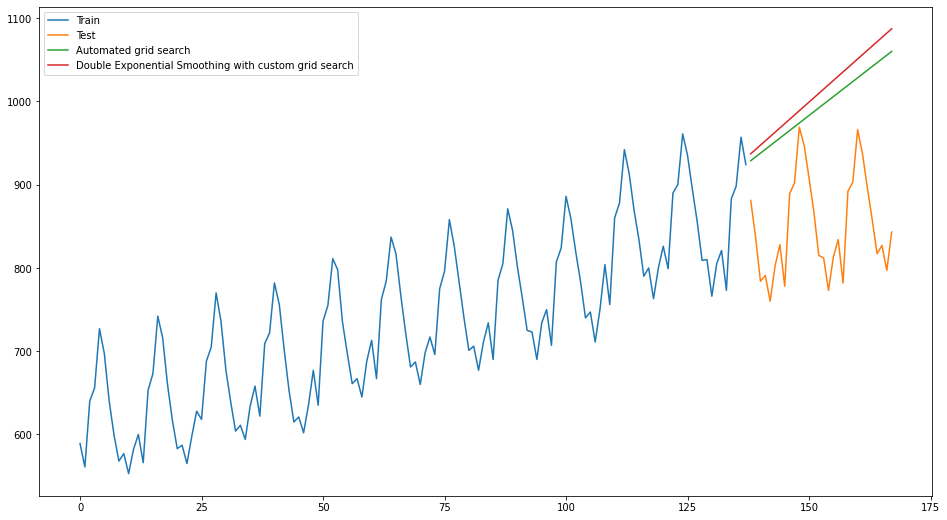

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Double Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

### 3) Triple Exponential Smoothing

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'trend': ['add', 'mul'],'seasonal' :['add', 'mul'],'seasonal_periods':[3,6,12], 'smoothing_level': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90], 'smoothing_slope':[0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],
              'damping_slope': [0.10, 0.20,.30,.40,.50,.60,.70,.80,.90],'damped' : [True, False], 'use_boxcox':[True, False],
             'remove_bias':[True, False],'use_basinhopping':[True, False]}
pg = list(ParameterGrid(param_grid))

In [ ]:
df_results_moni = pd.DataFrame(columns=['trend','seasonal_periods','smoothing_level', 'smoothing_slope',
                                        'damping_slope','damped','use_boxcox','remove_bias','use_basinhopping','RMSE','r2'])
start = timer()
print('Starting Grid Search..')
for a,b in enumerate(pg):
    trend = b.get('trend')
    smoothing_level = b.get('smoothing_level')
    seasonal_periods = b.get('seasonal_periods')
    smoothing_level = b.get('smoothing_level')
    smoothing_slope = b.get('smoothing_slope')
    damping_slope = b.get('damping_slope')
    damped = b.get('damped')
    use_boxcox = b.get('use_boxcox')
    remove_bias = b.get('remove_bias')
    use_basinhopping = b.get('use_basinhopping')
    #print(trend,smoothing_level, smoothing_slope,damping_slope,damped,use_boxcox,remove_bias,use_basinhopping)
    fit1 = ExponentialSmoothing(train,trend=trend, damped=damped,seasonal_periods=seasonal_periods ).fit(smoothing_level=smoothing_level,
                                    smoothing_slope=smoothing_slope, damping_slope = damping_slope,use_boxcox=use_boxcox,optimized=False)
    #fit1.summary
    z = fit1.forecast(30)
    #print(z)
    df_pred = pd.DataFrame(z, columns=['Forecasted_result'])
    RMSE = np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))
    r2 = metrics.r2_score(test, df_pred.Forecasted_result)
    #print( f' RMSE is {np.sqrt(metrics.mean_squared_error(test, df_pred.Forecasted_result))}')
    df_results_moni = df_results_moni.append({'trend':trend,'seasonal_periods':seasonal_periods,'smoothing_level':smoothing_level, 'smoothing_slope':smoothing_slope,
                                        'damping_slope':damping_slope,'damped':damped,'use_boxcox':use_boxcox,'use_basinhopping':use_basinhopping,'RMSE':RMSE,'r2':r2}, ignore_index=True)
print('End of Grid Search')
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

Starting Grid Search..


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykerne

End of Grid Search
 Total time taken to complete grid search in seconds: 2930.562534029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: the 'damped'' keyw

In [ ]:
print(f' Below mentioned parameter gives least RMSE and r2')
df_results_moni.sort_values(by=['RMSE','r2']).head(1)

 Below mentioned parameter gives least RMSE and r2


trend seasonal_periods  smoothing_level  smoothing_slope  damping_slope  \
0   add                3              0.1              0.1            0.1   

  damped use_boxcox  remove_bias use_basinhopping       RMSE        r2  
0   True       True          NaN             True  59.090857 -0.011257

In [ ]:
df_results_moni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139968 entries, 0 to 139967
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   trend             139968 non-null  object 
 1   seasonal_periods  139968 non-null  object 
 2   smoothing_level   139968 non-null  float64
 3   smoothing_slope   139968 non-null  float64
 4   damping_slope     139968 non-null  float64
 5   damped            139968 non-null  object 
 6   use_boxcox        139968 non-null  object 
 7   remove_bias       0 non-null       float64
 8   use_basinhopping  139968 non-null  object 
 9   RMSE              139968 non-null  float64
 10  r2                139968 non-null  float64
dtypes: float64(6), object(5)
memory usage: 11.7+ MB


In [ ]:
fit1 = ExponentialSmoothing(train,trend='mul', damped=False,seasonal_periods=3 ).fit(smoothing_level=0.9,
                                    smoothing_slope=0.6, damping_slope = 0.6,use_boxcox=False,use_basinhopping = True,optimized=False)
Forecast_custom_pred = fit1.forecast(30)
fit1.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:207: FutureWarning: the 'damping_slope'' keyword is deprecated, use 'damping_trend' instead
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmod

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                Milk_prod   No. Observations:                  138
Model:             ExponentialSmoothing   SSE                         356140.164
Optimized:                        False   AIC                           1092.104
Trend:                   Multiplicative   BIC                           1103.813
Seasonal:                          None   AICC                          1092.745
Seasonal Periods:                  None   Date:                 Tue, 11 Oct 2022
Box-Cox:                          False   Time:                         17:29:49
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
smoothing_trend            0.6000000                 beta                False
initial_level              589.00000                  l.0                False
initial_trend              0.9524618                  b.0                False
------------------------------------------------------------------------------
"""

In [ ]:
timeseries_evaluation_metrics_func(test,Forecast_custom_pred)

Evaluation metric results:-
MSE is : 45082.45240584998
MAE is : 196.04624830065322
RMSE is : 212.32628759965164
MAPE is : 23.546070806596127
R2 is : -12.056545412007619



In [ ]:
# Fitting model with optimized =True
fitESAUTO = ExponentialSmoothing(train).fit(optimized= True, use_brute = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [ ]:
fitESAUTO.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                Milk_prod   No. Observations:                  138
Model:             ExponentialSmoothing   SSE                         275891.000
Optimized:                         True   AIC                           1052.870
Trend:                             None   BIC                           1058.725
Seasonal:                          None   AICC                          1053.171
Seasonal Periods:                  None   Date:                 Tue, 11 Oct 2022
Box-Cox:                          False   Time:                         17:29:49
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              589.00011                  l.0                 True
------------------------------------------------------------------------------
"""

In [ ]:
fitESAUTOpred = fitESAUTO.forecast(30)
timeseries_evaluation_metrics_func(test,fitESAUTOpred)

Evaluation metric results:-
MSE is : 8889.466739181678
MAE is : 81.93333369394144
RMSE is : 94.28396862235742
MAPE is : 10.03407293485807
R2 is : -1.5745211268408275



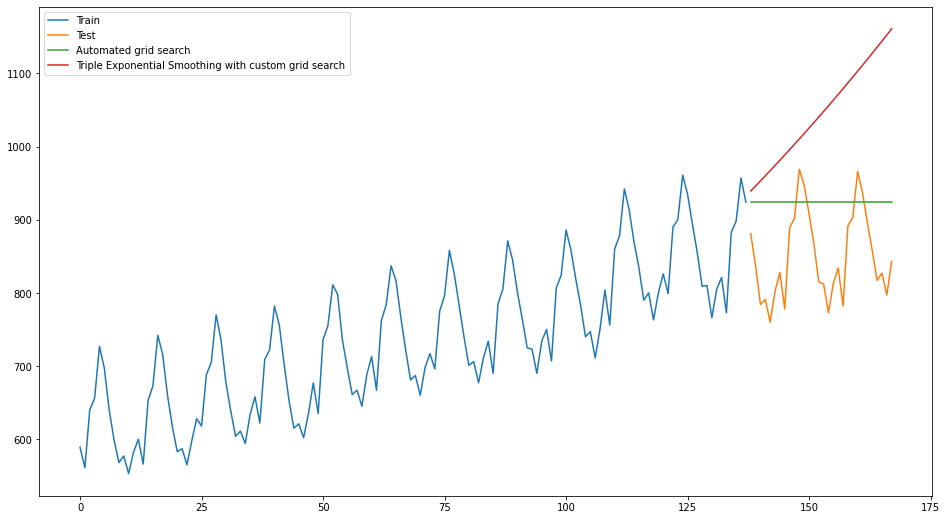

In [ ]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot( train, label='Train')
plt.plot(test, label='Test')
plt.plot(fitESAUTOpred, label='Automated grid search')
plt.plot(Forecast_custom_pred, label='Triple Exponential Smoothing with custom grid search')
plt.legend(loc='best')
plt.show()

In [ ]:
!jupyter nbconvert --execute --to pdf TSA_Exp4.ipynb

[NbConvertApp] WARNING | pattern 'TSA_Exp4' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute 

#Testing Stationarity

In [ ]:
milk = pd.read_csv(r'/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv', header=0, index_col=0)
milk.head()

Monthly milk production: pounds per cow
Month                                           
1962-01                                    589.0
1962-02                                    561.0
1962-03                                    640.0
1962-04                                    656.0
1962-05                                    727.0

In [ ]:
milk.rename(columns = {'Monthly milk production: pounds per cow':'Milk_Production'}, inplace = True)
milk.dropna(inplace = True)

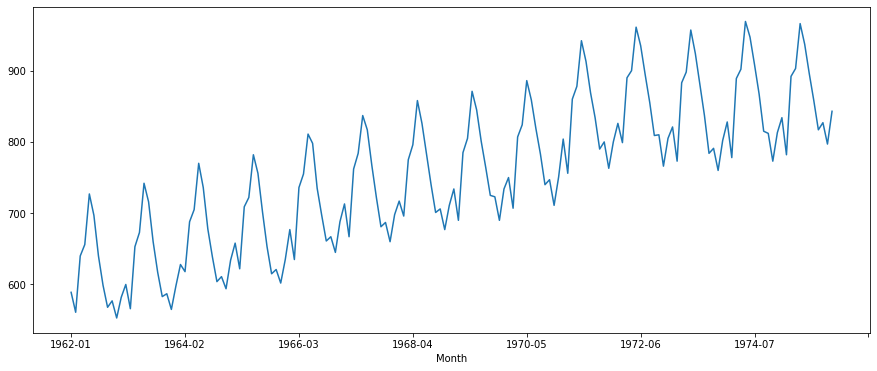

In [ ]:
milk['Milk_Production'].plot(figsize=(15,6))
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='aic') #AIC: Method to use when automatically determining the lag length among the values 0, 1, …, maxlag
    #The t-value measures the size of the difference relative to the variation in your sample data.
    #T is simply the calculated difference represented in units of standard error.
    #The greater the magnitude of T, the greater the evidence against the null hypothesis.

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','No of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value #Critical values for the ADF test for 1%, 5%, and 10% significance levels with the constant model are −3.43, −2.87, and −2.57, respectively.
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")


In [ ]:
Augmented_Dickey_Fuller_Test_func(milk['Milk_Production'],'Milk_Production')

Results of Dickey-Fuller Test for column: Milk_Production
Test Statistic              -1.303812
p-value                      0.627427
No Lags Used                13.000000
No of Observations Used    154.000000
Critical Value (1%)         -3.473543
Critical Value (5%)         -2.880498
Critical Value (10%)        -2.576878
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


a. Calculate the following:

> i.	Test Statistic -1.303812

> ii.	p-value 0.627427

> iii.	No Lags Used 13.000000

> iv.	Number of Observations Used 154.000000

> v.	Critical Value

>
*   1%   : -3.473543
*   5%   : -2.880498
*   10%  : -2.576878

b.	Conclude if the time series data contains unit roots or not.

> The time series data contains unit roots.

c. 	Also, infer if the data is stationary or not.
> Data is not stationary.


d. Apply differencing if the data is not stationary.

> We apply first differencing as follows:





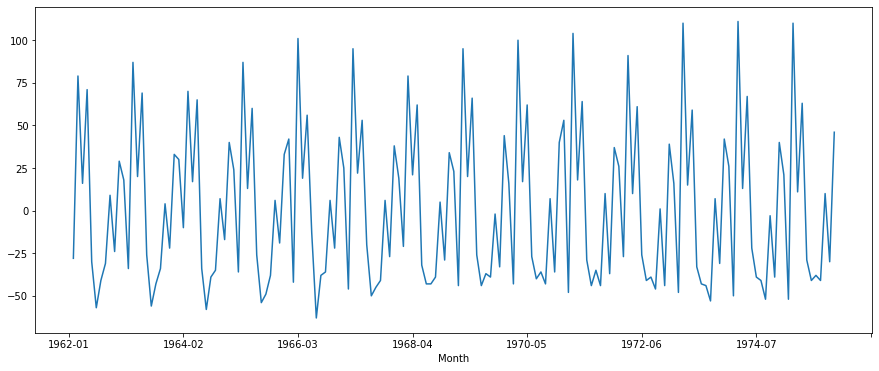

In [ ]:
milk['Milk_Production'].diff().plot(figsize=(15,6))

In [ ]:
milk_firstdiff = milk['Milk_Production'].diff()
Augmented_Dickey_Fuller_Test_func(milk_firstdiff.dropna(),'Milk Production')

Results of Dickey-Fuller Test for column: Milk Production
Test Statistic              -3.054996
p-value                      0.030068
No Lags Used                14.000000
No of Observations Used    152.000000
Critical Value (1%)         -3.474121
Critical Value (5%)         -2.880750
Critical Value (10%)        -2.577013
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


a. Calculate the following:

> i.	Test Statistic -3.054996

> ii.	p-value  0.030068

> iii.	No Lags Used 14.000000

> iv.	Number of Observations Used 152.000000

> v.	Critical Value

>
*   1%   : -3.474121
*   5%   : -2.880750
*   10%  : -2.577013

b.	Conclude if the time series data contains unit roots or not.

> The time series data does not contain unit roots anymore.

c. 	Also, infer if the data is stationary or not.
> Data is now stationary.


d. Apply differencing if the data is not stationary.

> Now the data is stationary.





#Implementation and interpretation for forecast

##Model 1: ARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv', parse_dates = True)

In [ ]:
df.head(5)

Month  Monthly milk production: pounds per cow
0  1962-01                                    589.0
1  1962-02                                    561.0
2  1962-03                                    640.0
3  1962-04                                    656.0
4  1962-05                                    727.0

In [ ]:
df.dropna(inplace=True)
df.rename(columns = {'Monthly milk production: pounds per cow':'Milk_Prod'}, inplace = True)
df.head(5)

Month  Milk_Prod
0  1962-01      589.0
1  1962-02      561.0
2  1962-03      640.0
3  1962-04      656.0
4  1962-05      727.0

###a.	Plot a histogram and compare the values with N (0,1).

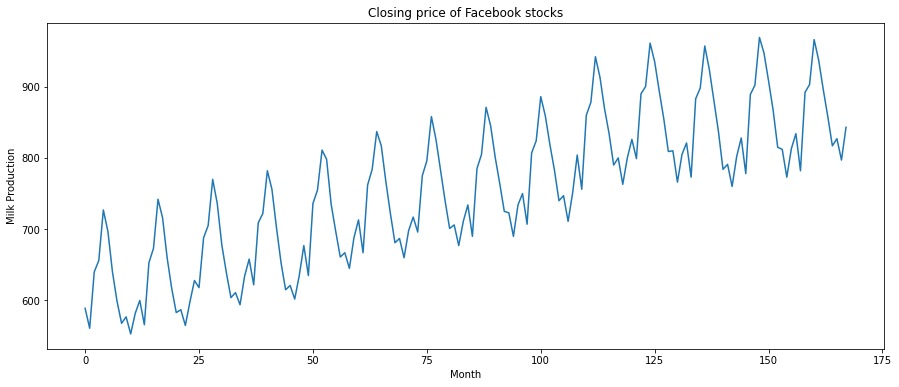

In [ ]:
df["Milk_Prod"].plot(figsize=(15, 6))
plt.xlabel("Month")
plt.ylabel("Milk Production")
plt.title("Closing price of Facebook stocks")
plt.show()

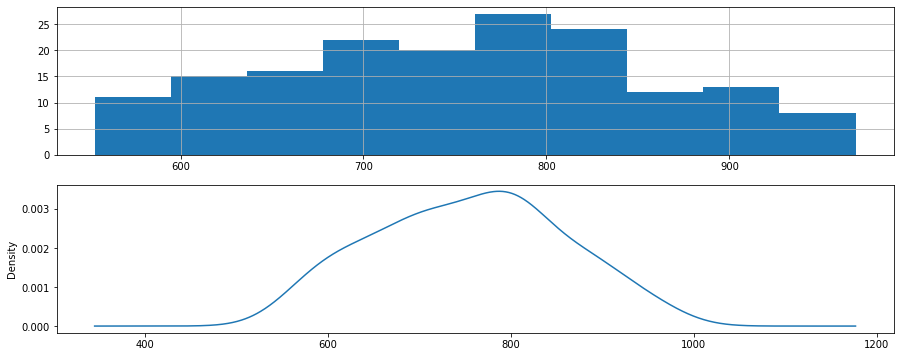

In [ ]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Milk_Prod"].hist()
plt.subplot(212)
df["Milk_Prod"].plot(kind='kde')
plt.show()

###b.	Check for Stationarity.

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df['Milk_Prod' ],'Milk_Prod')

Results of Dickey-Fuller Test for column: Milk_Prod
Test Statistic                  -1.303812
p-value                          0.627427
No Lags Used                    13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Close is non-stationary and auto-arima handles this internally.

###c.	State the coefficients which must be used for the appropriate model selected.

In [ ]:
X = df[['Milk_Prod']]
train, test = X[0:-30], X[-30:]

In [ ]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=True,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
print(stepwise_model)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1438.162, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1434.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1436.513, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1436.558, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1433.055, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.543 seconds
 ARIMA(0,1,0)(0,0,0)[0]          


In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  138
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -715.528
Date:                Fri, 02 Dec 2022   AIC                           1433.055
Time:                        14:30:47   BIC                           1435.975
Sample:                             0   HQIC                          1434.242
                                - 138                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2013.8117    292.256      6.891      0.000    1441.000    2586.624
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                11.40
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.60
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-ARIMA says **ARIMA(0,1,0)** is the optimal selection for the dataset.

Forecast both results and the confidence for the next 30 months and store it in a DataFrame.

**Confidence** is the range of values you expect your estimate to fall between if you redo your test, within a certain level of confidence.

**return_conf_int=True:** Whether to get the confidence intervals of the forecasts.

###d.	Calculate the evaluation metrics (MSE, RMSE, MAPE and R2).

In [ ]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['milk_prod_pred'])

In [ ]:
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(138, 168)
df_conf = df_conf.set_index("new_index")

In [ ]:
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 8889.466666666667
MAE is : 81.93333333333334
RMSE is : 94.28396823780099
MAPE is : 10.034072890491244
R2 is : -1.5745211058394069



###e.	Forecast the future values and plot Confidence Interval Upper bound and Confidence Interval Lower bound with respect to train, test and predicted.

In [ ]:
forecast["new_index"] = range(138, 168)
forecast = forecast.set_index("new_index")

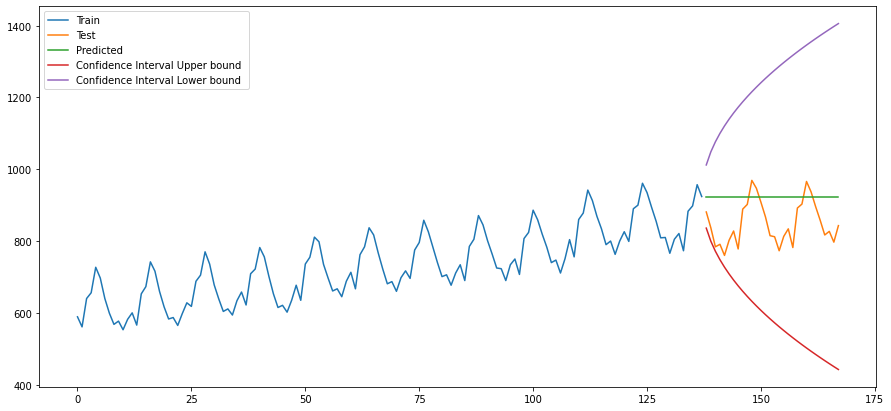

In [ ]:
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

###f.	Analyse the actual data with predicted based on the plots:
i.	Standardize Residual

ii.	Histogram plus estimated density

iii.	Normal Q-Q

iv.	Correlogram


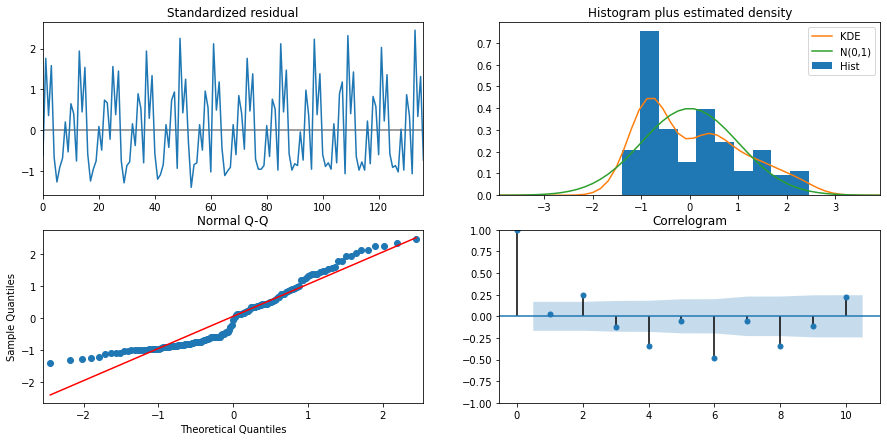

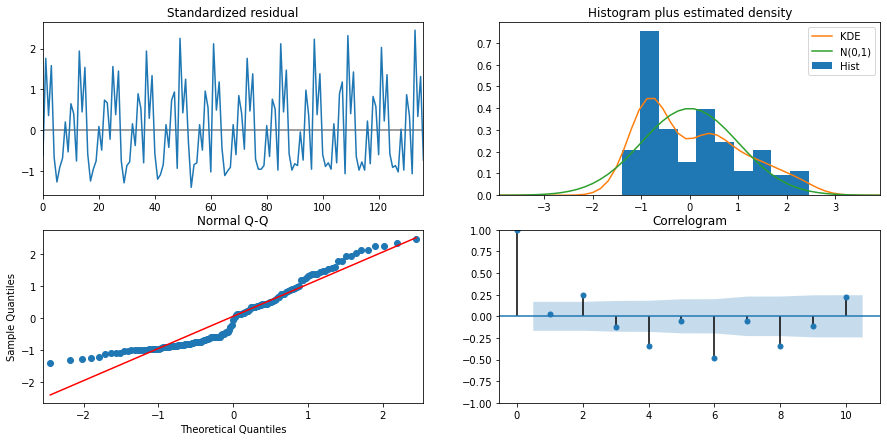

In [ ]:
stepwise_model.plot_diagnostics()

In [ ]:
forecast

milk_prod_pred
new_index                
138                 924.0
139                 924.0
140                 924.0
141                 924.0
142                 924.0
143                 924.0
144                 924.0
145                 924.0
146                 924.0
147                 924.0
148                 924.0
149                 924.0
150                 924.0
151                 924.0
152                 924.0
153                 924.0
154                 924.0
155                 924.0
156                 924.0
157                 924.0
158                 924.0
159                 924.0
160                 924.0
161                 924.0
162                 924.0
163                 924.0
164                 924.0
165                 924.0
166                 924.0
167                 924.0

##Model 2: CNN

a. Import all the libraries from Keras for neural network architectures.  

In [ ]:
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

b. Define a function that extracts features (lagged values)

In [ ]:
def split_sequence(sequence,steps):
  X,y=[],[]
  for start in range(len(sequence)):
    end_index = start+steps
    if end_index>len(sequence)-1:
      break
    sequence_x,sequence_y = sequence[start:end_index],sequence[end_index]
    X.append(sequence_x)
    y.append(sequence_y)
  return(array(X),array(y))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df = df.dropna()
df.head()

Month  Monthly milk production: pounds per cow
0  1962-01                                    589.0
1  1962-02                                    561.0
2  1962-03                                    640.0
3  1962-04                                    656.0
4  1962-05                                    727.0

c. Initializing Sequence, steps, and reshaping the output to input it to our CNN model.

In [ ]:
raw_sequence = df["Monthly milk production: pounds per cow"]

steps=3
X,y = split_sequence(raw_sequence,steps)

print("The input raw sequence on which we will test our CNN model: ",raw_sequence)
print("The features (X), lagged values of time series, for our CNN model: ",X)
print("The respectice observed values (y)of the sequence for training our CNN model: ",y)


The input raw sequence on which we will test our CNN model:  0      589.0
1      561.0
2      640.0
3      656.0
4      727.0
       ...  
163    858.0
164    817.0
165    827.0
166    797.0
167    843.0
Name: Monthly milk production: pounds per cow, Length: 168, dtype: float64
The features (X), lagged values of time series, for our CNN model:  [[589. 561. 640.]
 [561. 640. 656.]
 [640. 656. 727.]
 [656. 727. 697.]
 [727. 697. 640.]
 [697. 640. 599.]
 [640. 599. 568.]
 [599. 568. 577.]
 [568. 577. 553.]
 [577. 553. 582.]
 [553. 582. 600.]
 [582. 600. 566.]
 [600. 566. 653.]
 [566. 653. 673.]
 [653. 673. 742.]
 [673. 742. 716.]
 [742. 716. 660.]
 [716. 660. 617.]
 [660. 617. 583.]
 [617. 583. 587.]
 [583. 587. 565.]
 [587. 565. 598.]
 [565. 598. 628.]
 [598. 628. 618.]
 [628. 618. 688.]
 [618. 688. 705.]
 [688. 705. 770.]
 [705. 770. 736.]
 [770. 736. 678.]
 [736. 678. 639.]
 [678. 639. 604.]
 [639. 604. 611.]
 [604. 611. 594.]
 [611. 594. 634.]
 [594. 634. 658.]
 [634. 658. 622.]
 [658

d. Reshaping the X matrices

In [ ]:
features = 1
X = X.reshape((X.shape[0],X.shape[1],features))

print("After reshaping, the shape of input X",X.shape)
print("Final form of input feature matrix X",X)
print("Feature matrix X is ready for input to CNN model. We have used feature engineering to convert a sequence to matrix with image matrix shape to find patterns in sequence.")

After reshaping, the shape of input X (165, 3, 1)
Final form of input feature matrix X [[[589.]
  [561.]
  [640.]]

 [[561.]
  [640.]
  [656.]]

 [[640.]
  [656.]
  [727.]]

 [[656.]
  [727.]
  [697.]]

 [[727.]
  [697.]
  [640.]]

 [[697.]
  [640.]
  [599.]]

 [[640.]
  [599.]
  [568.]]

 [[599.]
  [568.]
  [577.]]

 [[568.]
  [577.]
  [553.]]

 [[577.]
  [553.]
  [582.]]

 [[553.]
  [582.]
  [600.]]

 [[582.]
  [600.]
  [566.]]

 [[600.]
  [566.]
  [653.]]

 [[566.]
  [653.]
  [673.]]

 [[653.]
  [673.]
  [742.]]

 [[673.]
  [742.]
  [716.]]

 [[742.]
  [716.]
  [660.]]

 [[716.]
  [660.]
  [617.]]

 [[660.]
  [617.]
  [583.]]

 [[617.]
  [583.]
  [587.]]

 [[583.]
  [587.]
  [565.]]

 [[587.]
  [565.]
  [598.]]

 [[565.]
  [598.]
  [628.]]

 [[598.]
  [628.]
  [618.]]

 [[628.]
  [618.]
  [688.]]

 [[618.]
  [688.]
  [705.]]

 [[688.]
  [705.]
  [770.]]

 [[705.]
  [770.]
  [736.]]

 [[770.]
  [736.]
  [678.]]

 [[736.]
  [678.]
  [639.]]

 [[678.]
  [639.]
  [604.]]

 [[639.]
  [60

e. Define the CNN model.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64,kernel_size=2,activation="relu",input_shape=(steps,features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

f. Implement CNN Model Fitting.

In [ ]:
model.fit(X,y,epochs=1000,verbose=0)

g. Predict the future values.

In [ ]:
y_pred=[]
for i in range(138,168):
  x_input = array(raw_sequence[i-3:i])
  x_input = x_input.reshape((1,steps,features))
  mp = model.predict(x_input,verbose=0)[0]
  yp = y_pred.append(mp[0])

print(f"The predicted values for the sequence {raw_sequence} for data points between 138 and 167")
print("are",y_pred)

The predicted values for the sequence 0      589.0
1      561.0
2      640.0
3      656.0
4      727.0
       ...  
163    858.0
164    817.0
165    827.0
166    797.0
167    843.0
Name: Monthly milk production: pounds per cow, Length: 168, dtype: float64 for data points between 138 and 167
are [936.11865, 851.8923, 806.4495, 764.918, 759.4829, 751.2463, 782.10986, 804.2042, 798.2645, 905.5056, 933.19794, 949.1377, 952.9298, 879.4255, 833.7303, 794.5124, 779.2638, 765.1379, 791.50665, 809.9722, 801.0512, 907.78906, 934.03955, 944.1784, 946.4997, 866.2094, 821.7299, 787.6525, 789.60724, 786.5853]


h. Plot the graph the predicted value.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv')
df = df.dropna()
raw_sequence = df["Monthly milk production: pounds per cow"][-30:]
pred= {"Actual Values": raw_sequence, "Predicted values":[936.11865, 851.8923, 806.4495, 764.918, 759.4829, 751.2463, 782.10986, 804.2042, 798.2645, 905.5056, 933.19794, 949.1377, 952.9298, 879.4255, 833.7303, 794.5124, 779.2638, 765.1379, 791.50665, 809.9722, 801.0512, 907.78906, 934.03955, 944.1784, 946.4997, 866.2094, 821.7299, 787.6525, 789.60724, 786.5853]}
df = pd.DataFrame(pred)
df

Actual Values  Predicted values
138          881.0         936.11865
139          837.0         851.89230
140          784.0         806.44950
141          791.0         764.91800
142          760.0         759.48290
143          802.0         751.24630
144          828.0         782.10986
145          778.0         804.20420
146          889.0         798.26450
147          902.0         905.50560
148          969.0         933.19794
149          947.0         949.13770
150          908.0         952.92980
151          867.0         879.42550
152          815.0         833.73030
153          812.0         794.51240
154          773.0         779.26380
155          813.0         765.13790
156          834.0         791.50665
157          782.0         809.97220
158          892.0         801.05120
159          903.0         907.78906
160          966.0         934.03955
161          937.0         944.17840
162          896.0         946.49970
163          858.0         866.20940
164          817.0         821.72990
165          827.0         787.65250
166          797.0         789.60724
167          843.0         786.58530

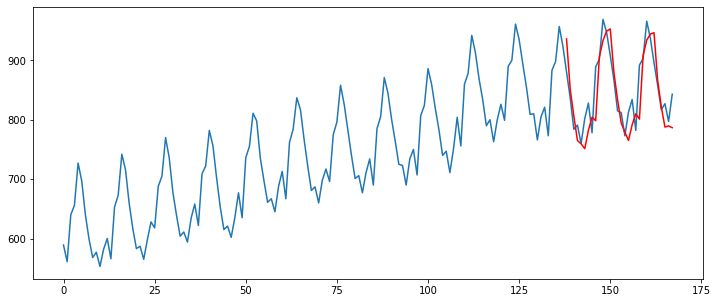

In [ ]:
df["Monthly milk production: pounds per cow"].plot(figsize=(12,5))
plt.plot([i for i in range(138,168)], y_pred, color='r')

In [ ]:
mprod = df['Monthly milk production: pounds per cow']
mprod = list(mprod[138:168])
timeseries_evaluation_metrics_func(y_pred, mprod)

Evaluation metric results:-
MSE is : 1462.8468736467262
MAE is : 29.790791829427082
RMSE is : 38.24718125099844
MAPE is : 3.602589316922293
R2 is : 0.679653367397139



Using CNN:

Evaluation metric results:-


> MSE is : 8889.466666666667

> MAE is : 81.93333333333334

> RMSE is : 94.28396823780099

> MAPE is : 10.034072890491244

> R2 is : -1.5745211058394069


Using CNN:

Evaluation metric results:-

> MSE is : 1462.8468736467262

> MAE is : 29.790791829427082

> RMSE is : 38.24718125099844

> MAPE is : 3.602589316922293

> R2 is : 0.679653367397139


##Model 3: GARCH

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from random import gauss
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
mp = pd.read_csv('/content/drive/MyDrive/Time Series Analysis/monthly-milk-production-pounds.csv',parse_dates= True)
mp.head()

Month  Monthly milk production: pounds per cow
0  1962-01                                    589.0
1  1962-02                                    561.0
2  1962-03                                    640.0
3  1962-04                                    656.0
4  1962-05                                    727.0

In [ ]:
mp.dropna(inplace=True)
mp.rename(columns={"Monthly milk production: pounds per cow": "Monthly_Prod"},inplace=True)
mp.head()

Month  Monthly_Prod
0  1962-01         589.0
1  1962-02         561.0
2  1962-03         640.0
3  1962-04         656.0
4  1962-05         727.0

In [ ]:
returns = 100*mp.Monthly_Prod.pct_change().dropna()

Text(0.5, 1.0, 'Milk Production')

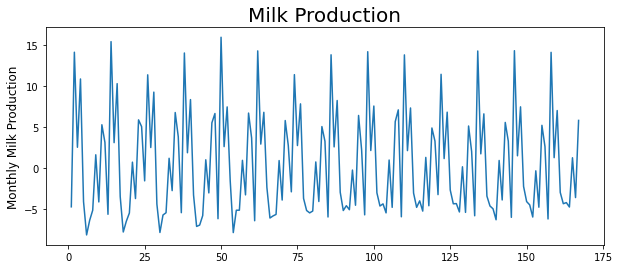

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Monthly Milk Production',fontsize=12)
plt.title('Milk Production',fontsize=20)

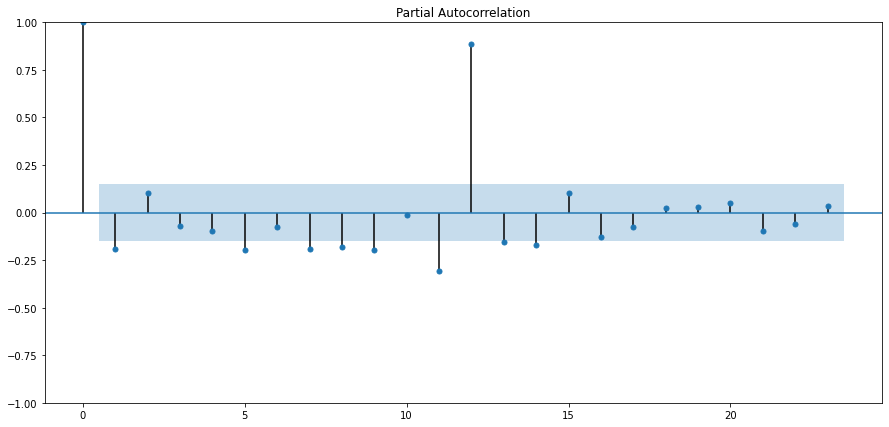

In [ ]:
plot_pacf(returns**2)
plt.show()

Our model does not have any volatilty hence, the above plot shows no PACF value above the threshold. Hence, we can say that GARCH is not a suitable model for out dataset.

In [ ]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1202.9208846663814
Iteration:      2,   Func. Count:     14,   Neg. LLF: 540.9095886668101
Iteration:      3,   Func. Count:     19,   Neg. LLF: 540.8783201528573
Iteration:      4,   Func. Count:     24,   Neg. LLF: 540.8732188976921
Iteration:      5,   Func. Count:     29,   Neg. LLF: 540.8308154548415
Iteration:      6,   Func. Count:     34,   Neg. LLF: 542.2548509531562
Iteration:      7,   Func. Count:     40,   Neg. LLF: 541.2846486735282
Iteration:      8,   Func. Count:     46,   Neg. LLF: 541.0363190706321
Iteration:      9,   Func. Count:     52,   Neg. LLF: 541.2907611979283
Iteration:     10,   Func. Count:     58,   Neg. LLF: 4985.12373328337
Iteration:     11,   Func. Count:     66,   Neg. LLF: 540.7738193714922
Iteration:     12,   Func. Count:     72,   Neg. LLF: 540.5895752325059
Iteration:     13,   Func. Count:     77,   Neg. LLF: 540.8246805998508
Iteration:     14,   Func. Count:     83,   Neg. LLF: 540.635600

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Monthly_Prod   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -540.521
Distribution:                  Normal   AIC:                           1089.04
Method:            Maximum Likelihood   BIC:                           1101.51
                                        No. Observations:                  167
Date:                Fri, Dec 02 2022   Df Residuals:                      166
Time:                        14:31:38   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3836      0.390      0.985      0.325 [ -0.380,  1.147]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.4778      1.050      0.455      0.649      [ -1.581,  2.537]
alpha[1]       0.0000  5.070e-02      0.000      1.000 [-9.937e-02,9.937e-02]
beta[1]        0.9846  5.557e-02     17.717  3.082e-70      [  0.876,  1.094]
=============================================================================

Covariance estimator: robust
"""

In [ ]:
rolling_pred = []
test_size=365
for i in range(test_size):
  train = returns[:-(test_size-i)]
  model = arch_model(train,p=1,q=0)
  model_fit = model.fit(disp='off')
  pred = model_fit.forecast(horizon=1)
  rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))

In [ ]:
rolling_pred = pd.Series(rolling_pred,index = returns.index[-365:])

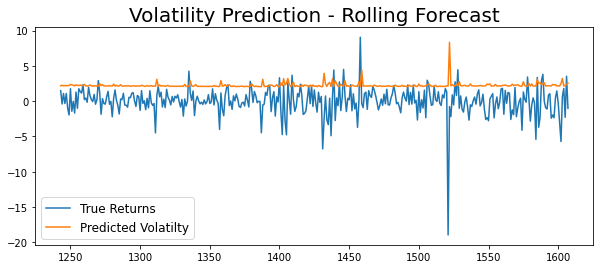

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_pred)
plt.title("Volatility Prediction - Rolling Forecast",fontsize = 20)
plt.legend(['True Returns','Predicted Volatilty'],fontsize=12,loc='lower left')